In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time
import scipy

#Separate import for numpy and jax.numpy to have major felxibility
import jax.numpy as jnp
import numpy as np
from jax import jit,lax,random
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions
from tensorflow_probability.substrates import jax as jtfp
jtfd = jtfp.distributions

np.random.seed(0)

In [157]:
sampled_perturbed = np.load('sampled_2D_two_clusters.npy')
data = sampled_perturbed[0 : 1000]
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 8
d = 2
#Key to store for random generation
rng_key = random.PRNGKey(0)
uniq_vals_recorded = []
cluster_allocs_recorded = []

In [232]:
def run_one_gibbs(data, cluster_allocs, uniq_vals, weights, alpha, lam,count,count_tot):
    
    """
    Run one gibbs sampler iteration
    Takes in input values of the previous iteration and sample the new values from sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
    Returns:   
    
    -cluster_allocs: for every data point, the cluster assigned
    -uniq_vals: array of parameters of the distributions. Matrix has d rows of the type:[mu[0], var[0,0], var[0,1]]
    -weights: array with the weights of the clusters 
     """
    
    n_clus = len(weights)
    
    for h in range(n_clus):
        
        #Extract data assigned to cluster h and sample 
        clusdata = data[cluster_allocs == h]
        if len(clusdata) != 0:
            #print(uniq_vals)
            #print(":::::")
            #print(uniq_vals[h, :])
            #uniq_vals[h, :] = sample_uniq_vals_fullcond(clusdata, lam)
            uniq_vals[h, :], acc_rate,count,count_tot = sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, lam, uniq_vals, h,count,count_tot)
            #print(uniq_vals)
            #print(":::::")
            #print(uniq_vals[h, :])
        else:
            print("sono qua")
            uniq_vals[h, :], acc_rate,count,count_tot = sample_uniq_vals_prior_Wasserstein_NW_log(lam, uniq_vals, h,count,count_tot)

    weights = update_weights(cluster_allocs ,n_clus, k, alpha)
    #print(weights)
    
    cluster_allocs = update_cluster_allocs(data, weights, uniq_vals)
    #print(cluster_allocs)
    
    #Save the values so that if we stop the kernel we have a visual output 
    global cluster_allocs_recorded
    cluster_allocs_recorded = cluster_allocs

    global uniq_vals_recorded
    uniq_vals_recorded = uniq_vals
    
    return cluster_allocs, uniq_vals, weights,count,count_tot




def run_mcmc(data, k , niter=1000, nburn=300, thin=5 ): 
    
    """
    Runs entire MCMC
    Takes in input data, number of clusters, number of iterations, burn-in and thin
    Returns the parameters recorded after burn-in phase
    """
    
    b = time.time() # only to measure time
    count = 0
    count_tot = 0
    
    #Priors
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k)/k
    alpha = 0.1
    lam = 0.1
    uniq_vals = np.dstack([
        tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
        #[[5,5],[-5,-5],[10,-10],[-10,10]],
        tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
    
    #Output values
    allocs_out = []
    uniq_vals_out = []
    weights_out = []
    
    #Useful value
    data_mean = np.mean(data, axis = 0)
    
    #Iterations
    for i in range(niter):
        cluster_allocs, uniq_vals, weights ,count,count_tot = run_one_gibbs(
            data, cluster_allocs, uniq_vals, weights, alpha, lam,count,count_tot)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            uniq_vals_out.append(uniq_vals.copy())
            weights_out.append(weights)
            
        if i % 10 == 0:
            a = time.time()
            print(uniq_vals)
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            
    return allocs_out, uniq_vals_out, weights_out

In [252]:
def sigmoid(x):
    return (1 - np.exp(-x))/(1 + np.exp(-x))


def sample_uniq_vals_fullcond_Wasserstein_NW_log(clusdata, lam, uniq_vals, h,count,count_tot):
    """
    Perform one step of the Metropolis Hastings step to sample a couple (mu,cov) from NIW*Wasserstein
    """

    count_tot = count_tot + 1
    
    #cov_prop: covariance matrix for the mean sampling
    #nu_prop: precision parameter in the Wishart
    cov_prop = 0.1*np.eye(2)
    nu_prop = 1000

    #Starting point of MH
    mu_old = np.array([uniq_vals[h,0,0], uniq_vals[h,1,0]])
    cov_old = np.array([[uniq_vals[h,0,1], uniq_vals[h,0,2]], 
                        [uniq_vals[h,1,1], uniq_vals[h,1,2]]])
    

    # Compute the parameters of the updated NIW
    mu_n, lam_n, phi_n, nu_n = compute_param_conjugate_NIW(clusdata, lam)
    
    # Sample the proposal using a centered Normal Wishart
    mu, cov = sample_from_NW(mu_old, cov_prop, cov_old, nu_prop)
    #mu, cov = sample_from_NW(mu_n, cov_prop, np.linalg.inv(phi_n), nu_prop)

    #print("Mu_old: " + str(mu_old))
    #print("Mu: " + str(mu))
    #print("Cov_old: " + str(cov_old))
    #print("Cov: " + str(cov))
    
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_log(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old,cov_prop,nu_prop)
    
    accept_rate = np.minimum(0, beta)
    
    draw = tfd.Uniform().sample()
    
    # Select the new or old values without an if to help JAX implementation
    if(np.log(draw) >= accept_rate):
        mu = mu_old
        cov = cov_old
        #print("beta: " + str(beta) + " rejected")
    else:
        count = count + 1
        #print("beta: " + str(beta) + " accepted")
    

    print("Accept Rate:" + str(count/count_tot))
    return np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]) , accept_rate,count,count_tot


def sample_uniq_vals_prior_Wasserstein_NW_log(lam, uniq_vals, h,count,count_tot):
    """
    Perform one step of the Metropolis Hastings step to sample a couple (mu,cov) from NIW*Wasserstein
    """

    count_tot = count_tot + 1
    
    #cov_prop: covariance matrix for the mean sampling
    #nu_prop: precision parameter in the Wishart
    cov_prop = 0.1*np.eye(2)
    nu_prop = 100

    #Starting point of MH
    mu_old = np.array([uniq_vals[h,0,0], uniq_vals[h,1,0]])
    cov_old = np.array([[uniq_vals[h,0,1], uniq_vals[h,0,2]], 
                        [uniq_vals[h,1,1], uniq_vals[h,1,2]]])
    
    mu_0 = np.mean(np.array(data))
    lam_0 = lam
    phi_0 = np.diag(np.ones(d))
    nu_0 = d

    # Sample the proposal using a centered Normal Wishart
    mu, cov = sample_from_NW(mu_old, cov_prop, cov_old, nu_prop)
    #mu, cov = sample_from_NW(mu_n, cov_prop, np.linalg.inv(phi_n), nu_prop)

    #print("Mu_old: " + str(mu_old))
    #print("Mu: " + str(mu))
    #print("Cov_old: " + str(cov_old))
    #print("Cov: " + str(cov))
    
    
    # Compute acceptance rate(and return it for tuning)
    beta = compute_beta_NW_log(uniq_vals, h, mu, cov, mu_0, lam_0, phi_0, nu_0, mu_old, cov_old,cov_prop,nu_prop)
    
    accept_rate = np.minimum(0, beta)
    
    draw = tfd.Uniform().sample()
    
    # Select the new or old values without an if to help JAX implementation
    if(np.log(draw) >= accept_rate):
        mu = mu_old
        cov = cov_old
        #print("beta: " + str(beta) + " rejected")
    else:
        count = count + 1
        #print("beta: " + str(beta) + " accepted")
    

    print("Accept Rate:" + str(count/count_tot))
    return np.array([[mu[0], cov[0,0], cov[0,1]],[mu[1], cov[1,0], cov[1,1]]]) , accept_rate,count,count_tot



def compute_param_conjugate_NIW(clusdata, lam):
    """
    Compute parameters for the conjugate NIW distribution
    """
    n=len(clusdata)
    #print("n: " + str(n))
    mean_clus = np.mean(clusdata, axis = 0)
    mean_data = np.mean(data, axis = 0)
    
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(mean_clus - mean_data, mean_clus - mean_data)
    phi_n = (W0 + C + D)
    
    nu_n = d + n
    lam_n = lam + n
    mu_n = (lam * mean_data + n * mean_clus)/(lam+n)
    return mu_n, lam_n, phi_n, nu_n

def sample_from_NW(mu, cov_prop, sigma, a):
    """
    Sample from a NW given its parameters
    """
    chol = np.linalg.cholesky(sigma/a)
    cov = tfd.WishartTriL(df=a, scale_tril=chol).sample()
    
    draw = tfd.Uniform().sample()
    if draw > 0.1:
        mu = tfd.MultivariateNormalFullCovariance(mu, cov_prop).sample()
    else:
        print("PROVA ESTREMA")
        mu = tfd.MultivariateNormalFullCovariance([30,-30], cov_prop).sample()
        print("MU " + str(mu))
    return mu, cov


def compute_beta_NW_log(uniq_vals, h, mu, cov, mu_n, lam_n, phi_n, nu_n, mu_old, cov_old,cov_prop,nu_prop):
    
    # Target distribution terms
    num_1 = evaluate_NIW_log(mu, cov, mu_n, lam_n, phi_n, nu_n)
    den_1 = evaluate_NIW_log(mu_old, cov_old , mu_n, lam_n, phi_n, nu_n)
    
    prop_num = evaluate_NW_log(mu_old , cov_old , mu , cov_prop , cov , nu_prop)
    prop_den = evaluate_NW_log(mu , cov,mu_old , cov_prop , cov_old , nu_prop)

    # Wasserstein Distances
    sum_ = 0
    for j in range(k):
        if(j != k):
            mu_k = np.array([uniq_vals[j,0,0],uniq_vals[j,1,0]])
            cov_k = np.array( [uniq_vals[j,0,1:3] , uniq_vals[j,1,1:3]]  )
            sum_ = sum_ + np.log(compute_Wasserstein(mu , cov , mu_k , cov_k)) - np.log(compute_Wasserstein(mu_n , np.linalg.inv(phi_n) , mu_k, cov_k))


    
    print("num_1" + str(num_1))
    print("sum" + str(50*sum_))
    print("den_1" + str(den_1))
    print("prop_num" + str(prop_num))
    print("prop_den" + str(prop_den))
    return num_1 + 50* sum_ - den_1 + prop_num - prop_den


def evaluate_NIW_log(x_mu, x_cov, mu_n, lam_n, phi_n, nu_n):
    """
    Evaluate the likelihood given the parameters of a NIW
    """
    W = np.linalg.inv(phi_n)
    chol = np.linalg.cholesky(W) 
    inv_cov = np.linalg.inv(x_cov)

    f1 = tfd.WishartTriL(df=nu_n, scale_tril=chol).log_prob(inv_cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_n, x_cov/(lam_n)).log_prob(x_mu)
    return f1 + f2


def evaluate_NW_log(mu , cov, mu_center , cov_param , cov_center , nu_param):

    cov_center_chol = np.linalg.cholesky(cov_center/nu_param)
    f1 = tfd.WishartTriL(df=nu_param, scale_tril=cov_center_chol).log_prob(cov)
    f2 = tfd.MultivariateNormalFullCovariance(mu_center, cov_param).log_prob(mu)
    return f1+f2

def compute_Wasserstein(mu_1, cov_1, mu_2, cov_2):
    """
    Wasserstein distance for the Gaussian Case
    """
    norm = np.linalg.norm(mu_1 - mu_2, ord = 2)
    sqrt_C2 = scipy.linalg.sqrtm(cov_2)
    C1_sqrt_C2 = np.matmul(cov_1,sqrt_C2)
    sqrt_C2_C1_sqrt_C2 = np.matmul(sqrt_C2,C1_sqrt_C2)
    trace = np.trace(cov_1 + cov_2 - 2 * scipy.linalg.sqrtm(sqrt_C2_C1_sqrt_C2))

    return norm + trace

def update_weights(cluster_allocs, n_clus, k, alpha):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()

def update_cluster_allocs(data, weights, uniq_vals):
    #print(weights)
    logprobs = tfd.MultivariateNormalFullCovariance(uniq_vals[:,:,0], uniq_vals[:,:,1:3]).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/(np.sum(np.exp(logprobs), axis=1))[:,None]
    #for i in range(len(probs)):
    #    if np.sum(probs[i]) != 1:
    #        probs[i] = np.zeros(k)
    #        idx = np.random.randint(0,k)
    #        probs[i,idx] = 1
    #print(probs)
    return tfd.Categorical(probs=probs, validate_args=True).sample()





In [96]:
def sample_uniq_vals_prior(lam):
    
    chol = tf.linalg.cholesky(np.diag(np.ones(d))) 
    prec = tfd.WishartTriL(df=d, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis = 0), var/lam).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])
    

def sample_uniq_vals_fullcond(clusdata, lam):
    
    n=len(clusdata)
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(np.mean(clusdata, axis = 0)-np.mean(data, axis = 0),np.mean(clusdata, axis = 0)-np.mean(data, axis = 0))
    W = tf.linalg.inv(W0 + C + D)
    chol = tf.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=d+n, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance((lam * np.mean(np.array(data), axis = 0)+n*np.mean(clusdata, axis = 0))/(lam+n), var/(lam+n)).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])


In [253]:
#RUNNING THE MCMC
start = time.time()
allocs_out, uniq_vals_out, weights_out = run_mcmc(data, k , niter = 500,nburn = 200)
end = time.time()
print("Total time: " + str(end-start))


num_1-5063.843405407033
sum-415.70557734502194
den_1-5045.444574456307
prop_num7.5012949518799115
prop_den7.5527632452834705
Accept Rate:0.0
num_1-2842.2376915083773
sum-432.6405774024192
den_1-2620.3224230506644
prop_num2.801925707252979
prop_den2.942838510637517
Accept Rate:0.0
num_1-11066.161303850844
sum-308.04259954230326
den_1-11389.009712572151
prop_num7.31217202198797
prop_den7.327340352974596
Accept Rate:0.3333333333333333
num_1-41667.8069079359
sum-33.524883678809225
den_1-41370.28789896998
prop_num10.460885969044128
prop_den10.400929002363526
Accept Rate:0.25
num_1-180293.61528103083
sum-267.9458702608311
den_1-178981.38529779846
prop_num10.41228735376759
prop_den10.331467716043301
Accept Rate:0.2
num_1-4287.762147152141
sum-91.26482651954183
den_1-4217.6576444571665
prop_num3.55330197246473
prop_den3.8347846640561936
Accept Rate:0.16666666666666666
num_1-6898.624968181486
sum-458.36223277309773
den_1-6940.838445482195
prop_num6.144757535363668
prop_den6.148338151748975
Acce

sono qua
num_1-10.850822808819506
sum65.89922309172488
den_1-11.42386308981731
prop_num2.797795316352447
prop_den2.5268370209236064
Accept Rate:0.40816326530612246
num_1-12655.910294104482
sum-266.84274607273994
den_1-13096.328570146045
prop_num0.49885958607759484
prop_den0.5340674377851773
Accept Rate:0.42
sono qua
num_1-180.0871649897663
sum903.5901732012342
den_1-174.88466839855448
prop_num4.4510669741608275
prop_den4.685981544808303
Accept Rate:0.43137254901960786
PROVA ESTREMA
MU [ 29.7967083  -29.82583237]
num_1-47062.019421383404
sum515.5778515232809
den_1-74.93805198822338
prop_num-8884.779606150052
prop_den-8884.227341058428
Accept Rate:0.4230769230769231
sono qua
num_1-46.19405471657655
sum129.66603184937586
den_1-50.25174714663757
prop_num5.212905567121306
prop_den4.550045717322542
Accept Rate:0.4339622641509434
num_1-3037.83060720851
sum-44.2035923530533
den_1-3082.13970693854
prop_num3.8974840162089577
prop_den3.4571952771339993
Accept Rate:0.4444444444444444
sono qua
num_

num_1-19.22799552197125
sum87.72386693526771
den_1-17.02275535742686
prop_num3.1372093508634045
prop_den3.336473619866272
Accept Rate:0.5104166666666666
sono qua
PROVA ESTREMA
MU [ 29.619488   -30.31981448]
num_1-534.2959390069004
sum355.76181762753885
den_1-542.1785031015928
prop_num-4.729118235730482
prop_den-5.317131166728359
Accept Rate:0.5154639175257731
num_1-14265.43134844574
sum-153.15827226534805
den_1-12314.080135123339
prop_num-2.1017373847187777
prop_den-1.9149117259115123
Accept Rate:0.5102040816326531
sono qua
num_1-187.13544138098015
sum280.8071566393624
den_1-216.65380898125946
prop_num3.3835062206465203
prop_den2.1269027126870945
Accept Rate:0.5151515151515151
sono qua
num_1-25.225454956268113
sum27.022985423190892
den_1-25.057292838134572
prop_num6.404020922904014
prop_den6.968151450755219
Accept Rate:0.52
sono qua
num_1-620.624144245179
sum334.77791193237965
den_1-613.6166269331795
prop_num6.35947384104372
prop_den6.99483891669689
Accept Rate:0.5247524752475248
num_1

num_1-31.03304216735365
sum33.92125948159651
den_1-31.77446335973794
prop_num7.328476223265683
prop_den6.589060200747412
Accept Rate:0.5608108108108109
sono qua
num_1-646.1360087367078
sum310.4777909155671
den_1-704.2302360920102
prop_num6.18702146762738
prop_den6.626858947712696
Accept Rate:0.5637583892617449
num_1-1788.8701909796575
sum-252.70832508052354
den_1-1791.2407985267364
prop_num6.271793702669223
prop_den6.322045783585375
Accept Rate:0.56
sono qua
num_1-10.393838066238766
sum-87.0484066574661
den_1-9.60553708668763
prop_num2.6052250871837805
prop_den3.231669948767203
Accept Rate:0.5562913907284768
sono qua
num_1-19.40124563760417
sum86.56255480932661
den_1-19.99436926681529
prop_num4.416697504867231
prop_den4.19063355089692
Accept Rate:0.5592105263157895
sono qua
num_1-674.5822160244035
sum228.13763799026407
den_1-800.8340120978888
prop_num4.821279965298528
prop_den4.1005071772650705
Accept Rate:0.5620915032679739
num_1-12216.63082647351
sum-252.31601735166743
den_1-11887.40

num_1-9367.862205369584
sum-215.9324563805202
den_1-10664.800495901978
prop_num0.9292437247009744
prop_den0.4866157317476123
Accept Rate:0.5979381443298969
sono qua
num_1-136.98381220988975
sum212.83979771080595
den_1-122.54342292686707
prop_num2.8975044973141264
prop_den3.3457750606877523
Accept Rate:0.6
sono qua
num_1-36.58159219378384
sum37.47220154729815
den_1-40.311755168915894
prop_num7.184679479771403
prop_den6.912823844261339
Accept Rate:0.6020408163265306
sono qua
num_1-371.1538301765794
sum254.32487712288986
den_1-475.7167028952018
prop_num4.91593215190801
prop_den4.325533231423493
Accept Rate:0.6040609137055838
num_1-1631.7911653441079
sum-158.4410075599834
den_1-1390.0955551180773
prop_num6.643320242371452
prop_den6.651406383119443
Accept Rate:0.601010101010101
sono qua
num_1-10.433980810124268
sum56.97412662410216
den_1-10.080714055036417
prop_num-1.9961898624068422
prop_den-1.0727391854860766
Accept Rate:0.6030150753768844
sono qua
num_1-28.07524170381039
sum-10.796358705

num_1-1106.5245794234784
sum-241.8316586208336
den_1-994.9870209153038
prop_num5.439341646067032
prop_den5.55443982709512
Accept Rate:0.5853658536585366
sono qua
num_1-190.9417642850681
sum-117.86838542802789
den_1-190.0396984693004
prop_num2.672345001689134
prop_den3.2028762595016325
Accept Rate:0.582995951417004
sono qua
num_1-20.712953166914893
sum33.56525182300209
den_1-20.88254605585234
prop_num5.678773318832967
prop_den5.613513147511199
Accept Rate:0.5846774193548387
[[[ 3.07307516e+01  2.39766860e+00  2.41909965e-01]
  [-2.96884921e+01  2.41909965e-01  1.23268472e-01]]

 [[-7.95094419e-01  2.65025226e+00 -4.25556665e-01]
  [ 2.13480329e-01 -4.25556665e-01  2.10843054e+00]]

 [[ 3.13135894e+01  8.56587380e-01 -3.25869317e-01]
  [-3.11698987e+01 -3.25869317e-01  3.46237983e-01]]

 [[ 1.26698556e+00  5.32332601e-02  2.42943104e-01]
  [-4.58440294e-01  2.42943104e-01  2.02220220e+00]]

 [[ 2.74944848e+01  1.72307493e+00 -1.09561183e+00]
  [-2.60994061e+01 -1.09561183e+00  7.12240840

num_1-8783.614372734099
sum-187.11067114073728
den_1-8181.105735032097
prop_num2.3204029951002134
prop_den2.5991280375840837
Accept Rate:0.5379310344827586
sono qua
num_1-126.92081419017389
sum-109.47304520107748
den_1-150.42558297016691
prop_num3.38170355497071
prop_den3.406897265059013
Accept Rate:0.5360824742268041
sono qua
num_1-29.546490825313363
sum19.84347480716083
den_1-28.948615489771914
prop_num7.1433226422226825
prop_den7.382858428199921
Accept Rate:0.5376712328767124
sono qua
num_1-345.7315735260232
sum-6.639340803424554
den_1-288.87444784813
prop_num6.379862744750309
prop_den6.510130804408956
Accept Rate:0.5358361774744027
num_1-703.7675303720212
sum-121.01509560887163
den_1-672.8136982759554
prop_num4.059624246062671
prop_den3.870569867053777
Accept Rate:0.5340136054421769
sono qua
num_1-203.9657738325107
sum-55.131543461665366
den_1-190.0396984693004
prop_num2.4544037123774167
prop_den2.319740766207506
Accept Rate:0.5322033898305085
sono qua
num_1-24.142446159550314
sum7

num_1-798.76085256648
sum-165.46778038533733
den_1-669.7782448270732
prop_num5.275273468268505
prop_den5.336454323791667
Accept Rate:0.5
sono qua
num_1-155.76405638175694
sum-108.09267286347684
den_1-190.0396984693004
prop_num2.949566567857603
prop_den2.556794134712861
Accept Rate:0.49850746268656715
sono qua
num_1-23.23631216380883
sum39.64781746803855
den_1-24.142446159550314
prop_num5.139230170084488
prop_den5.170173244441003
Accept Rate:0.5
sono qua
num_1-352.2442232138397
sum-112.16365531888965
den_1-415.42413053408006
prop_num3.555375050227712
prop_den3.5073482987609332
Accept Rate:0.49851632047477745
num_1-6878.229007499577
sum-160.82312209133525
den_1-7270.215132381281
prop_num0.3373006540339092
prop_den0.6085717884181876
Accept Rate:0.5
sono qua
num_1-144.55669631326577
sum-78.63468817680972
den_1-150.42558297016691
prop_num5.302525253637802
prop_den5.228718007536051
Accept Rate:0.49852507374631266
sono qua
num_1-42.46533902240707
sum30.374696586047744
den_1-47.19176662283462


num_1-20.87545007569289
sum16.545319940262125
den_1-26.007591773255406
prop_num3.3996332110570693
prop_den1.7349021362585022
Accept Rate:0.46875
sono qua
num_1-341.7005256073873
sum-40.32333500690913
den_1-415.42413053408006
prop_num2.4909128333280792
prop_den2.140516152199436
Accept Rate:0.4701298701298701
num_1-6739.085803716013
sum-182.69340501274183
den_1-6451.061858870123
prop_num1.9284928674699278
prop_den1.7129347251475484
Accept Rate:0.4689119170984456
sono qua
num_1-138.5478875640421
sum-59.695193114759405
den_1-150.42558297016691
prop_num2.927510605157916
prop_den2.6399785349059317
Accept Rate:0.46770025839793283
sono qua
num_1-50.70543925369914
sum-43.59046292692595
den_1-54.62282594779718
prop_num8.432271802350847
prop_den8.779398067505447
Accept Rate:0.46649484536082475
sono qua
num_1-169.808102573148
sum-17.026301388545317
den_1-218.1489159107477
prop_num8.060238435273806
prop_den7.384424705096895
Accept Rate:0.46786632390745503
num_1-621.8652177433509
sum-181.15348394033

num_1-404.5131849194222
sum-191.02589715502737
den_1-522.2122552094634
prop_num6.004508125980298
prop_den5.884267877559811
Accept Rate:0.44651162790697674
sono qua
num_1-199.71964123186885
sum-111.29653694103834
den_1-190.0396984693004
prop_num3.134737163324374
prop_den3.4842845120612083
Accept Rate:0.44547563805104406
sono qua
num_1-32.50914153954258
sum49.629931843197795
den_1-35.17745809880816
prop_num6.675629533041841
prop_den6.677710442224649
Accept Rate:0.44675925925925924
sono qua
num_1-314.2926556669714
sum-65.28022652291055
den_1-341.7005256073873
prop_num1.0656330554509101
prop_den-0.3405725631138732
Accept Rate:0.4457274826789838
num_1-6290.760730437059
sum-201.49566542084264
den_1-6183.958943193966
prop_num4.0078249657509195
prop_den3.9916164333412416
Accept Rate:0.4447004608294931
sono qua
num_1-195.31273651223304
sum-86.05472563447775
den_1-150.42558297016691
prop_num-0.6364699960945668
prop_den1.7598582574170027
Accept Rate:0.4436781609195402
sono qua
num_1-49.3633561192

num_1-23.20829461361307
sum-13.582262802673705
den_1-25.84261000882305
prop_num5.457128893273349
prop_den4.6959872374530525
Accept Rate:0.41875
sono qua
num_1-304.8894409825499
sum-201.666375888784
den_1-341.7005256073873
prop_num4.364247500755345
prop_den4.172171652376795
Accept Rate:0.4178794178794179
num_1-5860.786993351814
sum-238.48905998413704
den_1-5876.224720283144
prop_num3.4453183445241073
prop_den3.5352889480577367
Accept Rate:0.4170124481327801
sono qua
num_1-171.7394041580902
sum-107.98630191566328
den_1-150.42558297016691
prop_num0.08241511744998631
prop_den0.498165655156217
Accept Rate:0.4161490683229814
sono qua
PROVA ESTREMA
MU [ 30.15082089 -30.14860319]
num_1-5110.548821962829
sum10.712225853154667
den_1-85.37875056634648
prop_num-7962.012035991568
prop_den-7961.32431486204
Accept Rate:0.4152892561983471
sono qua
num_1-188.4631941634296
sum-78.09633168561363
den_1-152.3959873020253
prop_num8.13547685731655
prop_den8.772111925574652
Accept Rate:0.4144329896907217
PROV

num_1-400.62611832681137
sum-181.38004569252985
den_1-529.7422951317674
prop_num5.614706384276542
prop_den5.506532684434387
Accept Rate:0.3935361216730038
sono qua
num_1-197.91814030942393
sum-238.47781344688187
den_1-190.0396984693004
prop_num3.205563778652305
prop_den3.5415411896627234
Accept Rate:0.3927893738140417
sono qua
num_1-28.32962012892768
sum-11.864478481774688
den_1-25.78150041900244
prop_num6.6254987295645975
prop_den7.046260690446772
Accept Rate:0.39204545454545453
sono qua
num_1-374.0930922321302
sum-155.25420871307603
den_1-341.7005256073873
prop_num3.581305492243816
prop_den3.5263039059042303
Accept Rate:0.391304347826087
num_1-5798.384960357073
sum-164.52070783484675
den_1-5853.517343409189
prop_num3.1209285648755767
prop_den3.213705819647167
Accept Rate:0.3905660377358491
sono qua
num_1-161.12217642022068
sum-128.60087014901058
den_1-150.42558297016691
prop_num3.5690733121528604
prop_den3.1361564265365383
Accept Rate:0.3898305084745763
sono qua
num_1-116.70485426936

num_1-167.12669714582313
sum21.85678097647964
den_1-135.6629233351786
prop_num7.16202816315263
prop_den7.789550716305374
Accept Rate:0.3723776223776224
sono qua
num_1-168.63649345107382
sum-78.48451236452296
den_1-152.3959873020253
prop_num6.432247815089853
prop_den5.6378529610130395
Accept Rate:0.3717277486910995
num_1-642.1858420321604
sum-212.19390981216145
den_1-540.1568234308982
prop_num4.184317051466168
prop_den4.5563283393848355
Accept Rate:0.3710801393728223
sono qua
PROVA ESTREMA
MU [ 30.25413707 -29.4242171 ]
num_1-216.57050269653425
sum-142.50170142434465
den_1-190.0396984693004
prop_num2.183140319289181
prop_den2.6337615938295627
Accept Rate:0.37043478260869567
sono qua
num_1-36.25853203667303
sum7.214979035330915
den_1-29.47203212796636
prop_num5.984913203176925
prop_den6.451638576332053
Accept Rate:0.3715277777777778
sono qua
num_1-330.47539389869286
sum-195.10312165239932
den_1-341.7005256073873
prop_num4.780056993181264
prop_den4.740180194708901
Accept Rate:0.3708838821

num_1-456.7699151619896
sum-190.25390109935032
den_1-529.6157437330328
prop_num6.070485080393178
prop_den5.959062773856454
Accept Rate:0.34565916398713825
sono qua
PROVA ESTREMA
MU [ 29.84355952 -30.00106269]
num_1-216.9086949860898
sum-147.05754570936898
den_1-190.0396984693004
prop_num0.8516854253726365
prop_den0.13921658659963043
Accept Rate:0.3451043338683788
sono qua
num_1-54.30295298853876
sum43.967733634596094
den_1-36.33824578924855
prop_num3.855195918876179
prop_den4.642740289009966
Accept Rate:0.34615384615384615
sono qua
num_1-359.2040990323733
sum-174.49469277984008
den_1-341.7005256073873
prop_num3.68928824950858
prop_den4.084032038880183
Accept Rate:0.3456
num_1-5437.352686985397
sum-168.16547427779102
den_1-5322.074116459043
prop_num2.621167472145564
prop_den2.7813355655094
Accept Rate:0.3450479233226837
sono qua
num_1-167.70509439837906
sum-99.49403121229238
den_1-150.42558297016691
prop_num3.932689617523918
prop_den4.211892089841312
Accept Rate:0.3444976076555024
sono 

num_1-130.6096261212604
sum1.9931970648204955
den_1-111.35472549964786
prop_num5.572599006776576
prop_den7.01341033359491
Accept Rate:0.3338323353293413
sono qua
num_1-141.7391776080329
sum-85.65660093722846
den_1-152.3959873020253
prop_num7.694412005397393
prop_den7.684129576774179
Accept Rate:0.3333333333333333
PROVA ESTREMA
MU [ 29.64949096 -29.97097067]
num_1-1795120.9509379922
sum-141.70960182219923
den_1-692.5039316365272
prop_num-8750.476886618573
prop_den-8750.392132079705
Accept Rate:0.3328358208955224
sono qua
num_1-206.38911815023167
sum-132.56625867988836
den_1-190.0396984693004
prop_num-1.8622070941993911
prop_den-2.1346755706724565
Accept Rate:0.3323397913561848
sono qua
num_1-35.95184920316777
sum21.255465778414983
den_1-34.35830130791285
prop_num5.620330004108432
prop_den5.668364414968686
Accept Rate:0.3333333333333333
sono qua
num_1-428.00610879525095
sum-161.3761945695343
den_1-341.7005256073873
prop_num2.1998512152504173
prop_den2.8869121116032357
Accept Rate:0.33283

num_1-916.8991057534356
sum-243.95117264564038
den_1-1014.0396802630885
prop_num4.452627597438289
prop_den4.032649273107461
Accept Rate:0.3203342618384401
sono qua
num_1-217.72755664023126
sum-205.41199398494078
den_1-190.0396984693004
prop_num3.114364081706432
prop_den3.5062491295561156
Accept Rate:0.3198887343532684
sono qua
num_1-47.95709746019563
sum25.373004817207946
den_1-42.771909812736965
prop_num7.395868744053139
prop_den7.481608295220134
Accept Rate:0.32083333333333336
sono qua
num_1-313.7737586623847
sum-157.0730378257171
den_1-341.7005256073873
prop_num2.404088578207069
prop_den1.8609747406290071
Accept Rate:0.32038834951456313
num_1-3621.9280645706376
sum-134.26916270140225
den_1-3431.2269479831443
prop_num1.7217414453438238
prop_den1.569733874295153
Accept Rate:0.31994459833795014
sono qua
num_1-193.59284400187474
sum-171.57937507523695
den_1-150.42558297016691
prop_num2.509257016844477
prop_den3.418292669982454
Accept Rate:0.31950207468879666
sono qua
num_1-115.242319214

num_1-108.01254709542704
sum-57.515350174831894
den_1-111.35472549964786
prop_num11.4910778686533
prop_den11.462463548065053
Accept Rate:0.3089005235602094
sono qua
num_1-127.82900247070009
sum-60.37446787273082
den_1-152.3959873020253
prop_num5.198910522229703
prop_den4.775235634121877
Accept Rate:0.3084967320261438
num_1-814.6316917132507
sum-243.34921049734945
den_1-899.3931446663897
prop_num2.9211932370651827
prop_den3.2232986470435496
Accept Rate:0.30809399477806787
sono qua
PROVA ESTREMA
MU [ 29.97104866 -30.06758758]
num_1-190.34338834383675
sum-216.48279935663118
den_1-190.0396984693004
prop_num3.62248779250314
prop_den3.804393938892094
Accept Rate:0.3076923076923077
sono qua
num_1-56.42280627931511
sum32.60725892812173
den_1-54.35211926280179
prop_num6.255810848239023
prop_den6.751266580613774
Accept Rate:0.30859375
sono qua
num_1-386.38835883410894
sum-171.30805663671563
den_1-341.7005256073873
prop_num0.7404206110701175
prop_den1.3027265937612178
Accept Rate:0.30819245773732

num_1-3421.818530096841
sum-147.60258568917757
den_1-3252.3526374874255
prop_num2.6491965032654314
prop_den2.645068177759628
Accept Rate:0.29876543209876544
sono qua
num_1-163.27907067594947
sum-162.99378370207768
den_1-150.42558297016691
prop_num3.553386015720868
prop_den3.6772867331463956
Accept Rate:0.29839704069050554
sono qua
num_1-101.41572120426524
sum-76.08692314328499
den_1-111.35472549964786
prop_num10.311284625363706
prop_den10.000393680443418
Accept Rate:0.29802955665024633
sono qua
PROVA ESTREMA
MU [ 30.2105526  -30.16106308]
num_1-326.55147929337977
sum-134.4913912101519
den_1-152.3959873020253
prop_num-126.68623266670491
prop_den-126.51441785472795
Accept Rate:0.2976629766297663
num_1-1312.9909439140042
sum-182.62355820395325
den_1-982.3533488720161
prop_num4.018977066460867
prop_den3.745361668641454
Accept Rate:0.2972972972972973
sono qua
num_1-165.54787602457185
sum-177.96559684759112
den_1-190.0396984693004
prop_num2.8537205043772698
prop_den2.25957859220191
Accept Ra

num_1-130.91761426977155
sum-75.33728226013488
den_1-111.35472549964786
prop_num8.134912604578028
prop_den9.41670409471734
Accept Rate:0.29069767441860467
sono qua
num_1-127.28528993309497
sum-103.84533019411846
den_1-152.3959873020253
prop_num7.879613786953752
prop_den7.439187354185589
Accept Rate:0.29036004645760743
num_1-1221.3704751642542
sum-219.65511753620817
den_1-1275.9152035378997
prop_num6.481186233362012
prop_den6.467608673037391
Accept Rate:0.2900232018561485
sono qua
num_1-213.073867198067
sum-188.84943889714427
den_1-190.0396984693004
prop_num2.771751840173073
prop_den2.866406321413186
Accept Rate:0.28968713789107764
sono qua
num_1-60.3835895245299
sum18.50775988955784
den_1-72.30164764505322
prop_num8.19682109185346
prop_den8.043407610445522
Accept Rate:0.29050925925925924
sono qua
PROVA ESTREMA
MU [ 29.9451809  -29.94821461]
num_1-328.32179923593145
sum-207.95181667329211
den_1-341.7005256073873
prop_num-27.37888356434452
prop_den-27.132959973114865
Accept Rate:0.290173

num_1-54.422489728536746
sum-25.286577570655886
den_1-46.08882884279754
prop_num6.9471093747736825
prop_den7.622568343841842
Accept Rate:0.2831858407079646
sono qua
num_1-325.0082718901541
sum-104.38228002588461
den_1-341.7005256073873
prop_num-0.18310362669612168
prop_den-0.9331631669281943
Accept Rate:0.2828729281767956
num_1-1658.2811358936945
sum-155.81911758339652
den_1-1722.7399296905953
prop_num1.6609285569424364
prop_den1.426608145679821
Accept Rate:0.282560706401766
sono qua
num_1-154.16865142800418
sum-206.3578029067087
den_1-150.42558297016691
prop_num5.339762598622919
prop_den5.664791507500247
Accept Rate:0.2822491730981257
sono qua
num_1-109.28299026054313
sum-88.22195494722382
den_1-111.35472549964786
prop_num6.217534560786452
prop_den7.866090356265805
Accept Rate:0.28193832599118945
sono qua
PROVA ESTREMA
MU [ 30.31010314 -30.42719476]
num_1-316.4882157276975
sum-146.91794758445582
den_1-152.3959873020253
prop_num-141.48479330966504
prop_den-141.30140702456126
Accept Rat

sono qua
num_1-302.23281472338715
sum-233.85296324539624
den_1-341.7005256073873
prop_num4.340190848081175
prop_den4.034050266061083
Accept Rate:0.2707240293809024
num_1-1783.5273393359118
sum-159.01064687537865
den_1-1680.8124743902822
prop_num2.8224850235167502
prop_den2.8517597930389535
Accept Rate:0.27044025157232704
sono qua
num_1-148.5774295040155
sum-180.718172374829
den_1-150.42558297016691
prop_num3.627180160292091
prop_den3.442151383621968
Accept Rate:0.27015706806282724
sono qua
num_1-120.36267998763132
sum-79.38542989595646
den_1-111.35472549964786
prop_num10.38168295068031
prop_den10.42190737627275
Accept Rate:0.2698744769874477
sono qua
num_1-176.00659581328395
sum-115.62139447380089
den_1-152.3959873020253
prop_num8.461283969123873
prop_den8.63385169362839
Accept Rate:0.26959247648902823
num_1-2528.834492199075
sum-164.50844047029912
den_1-1233.2326827707734
prop_num3.6527569346320945
prop_den3.6527704568021875
Accept Rate:0.26931106471816285
sono qua
num_1-220.665312893

num_1-919.6690927449506
sum-281.5087194933374
den_1-950.9358536643394
prop_num6.055790249744199
prop_den6.124159617272674
Accept Rate:0.26452905811623245
sono qua
num_1-215.99587027255387
sum-228.2466138391813
den_1-190.0396984693004
prop_num2.8329154195541344
prop_den3.388063979524156
Accept Rate:0.26426426426426425
sono qua
num_1-65.30671605324186
sum-42.28014547149821
den_1-55.37409010972519
prop_num5.701971315263924
prop_den6.946742267796614
Accept Rate:0.264
sono qua
num_1-285.6721761614196
sum-190.18984947448976
den_1-341.7005256073873
prop_num2.5225027137259284
prop_den2.2775493376058344
Accept Rate:0.26373626373626374
num_1-1800.29140731656
sum-102.75471692572418
den_1-1716.3625067632647
prop_num-1.4432579365319418
prop_den-1.6909554360751065
Accept Rate:0.2634730538922156
sono qua
num_1-182.0302012459449
sum-197.26523029172213
den_1-150.42558297016691
prop_num1.2000753593273052
prop_den2.133977903546357
Accept Rate:0.26321036889332006
sono qua
num_1-98.36092897666342
sum-76.81

num_1-78.9544020375902
sum48.15973285892758
den_1-62.48874995365746
prop_num2.0633315418286213
prop_den4.054547840324165
Accept Rate:0.25572519083969464
[[[ 3.24370499e+01  2.90050835e+00  3.08127273e-01]
  [-3.00170358e+01  3.08127273e-01  2.11038460e-01]]

 [[ 1.76515225e+00  4.71895961e+00  1.03137845e+00]
  [ 2.02263141e+00  1.03137845e+00  3.41198451e+00]]

 [[ 3.13135894e+01  8.56587380e-01 -3.25869317e-01]
  [-3.11698987e+01 -3.25869317e-01  3.46237983e-01]]

 [[ 3.55105348e+00  1.29267438e-02  2.98862281e-02]
  [-2.05146979e-01  2.98862281e-02  4.64013242e-01]]

 [[ 2.87378489e+01  9.89819333e-01 -6.92016132e-01]
  [-2.51604285e+01 -6.92016132e-01  5.03357008e-01]]

 [[-9.73662110e-01  5.83598123e+00  2.90756603e+00]
  [-2.35942204e+00  2.90756603e+00  1.58818714e+00]]

 [[ 3.00906092e+01  3.25864119e+00 -3.81115291e-01]
  [-2.99166943e+01 -3.81115291e-01  2.53212750e-01]]

 [[-5.62961384e+00  9.80691311e-01 -4.95614819e-01]
  [ 6.02468723e+00 -4.95614819e-01  2.66673480e-01]]]

num_1-713.5571580988058
sum-225.71654493777524
den_1-710.7806072572351
prop_num6.567367935861991
prop_den6.698338984117324
Accept Rate:0.2477148080438757
sono qua
PROVA ESTREMA
MU [ 29.93970113 -30.03053149]
num_1-230.14322830094613
sum-187.01315947713096
den_1-190.0396984693004
prop_num-1.250758860446064
prop_den-1.79164619516086
Accept Rate:0.24748858447488584
sono qua
num_1-95.14988586394531
sum3.901260288468267
den_1-82.5008869804706
prop_num6.960535116256778
prop_den7.180939106175571
Accept Rate:0.24726277372262773
sono qua
num_1-394.7145989998726
sum-229.72736023229464
den_1-341.7005256073873
prop_num3.9955026836689793
prop_den4.179437293482101
Accept Rate:0.24703737465815861
num_1-1519.337102847091
sum-118.4035104919598
den_1-1617.4417742687365
prop_num0.4348853139955198
prop_den0.5885146011199511
Accept Rate:0.24681238615664844
sono qua
num_1-148.2163339330095
sum-197.03331082543417
den_1-150.42558297016691
prop_num5.168236817495881
prop_den5.094426163264927
Accept Rate:0.24658

num_1-4772.141295615423
sum-61.932556982428075
den_1-111.35472549964786
prop_num-7953.4771234080545
prop_den-7953.539704444441
Accept Rate:0.2394736842105263
sono qua
num_1-161.72095415401049
sum-143.32416602906326
den_1-152.3959873020253
prop_num8.811976608430825
prop_den8.75859547333647
Accept Rate:0.2392638036809816
num_1-783.7362089318194
sum-185.97585311107082
den_1-743.6645101806898
prop_num6.199182019642951
prop_den6.205255193152727
Accept Rate:0.23905429071803852
sono qua
PROVA ESTREMA
MU [ 29.6725418  -30.38228412]
num_1-218.5213284779354
sum-166.34948500461334
den_1-190.0396984693004
prop_num1.9417491109951701
prop_den2.2443169046730507
Accept Rate:0.2388451443569554
sono qua
PROVA ESTREMA
MU [ 29.7849458 -30.4109246]
num_1-689.0810055223673
sum-132.7882232694175
den_1-75.7998507002718
prop_num-12231.17328969943
prop_den-12231.651456361584
Accept Rate:0.23863636363636365
sono qua
num_1-340.65884313549583
sum-203.33868856689082
den_1-341.7005256073873
prop_num2.212687373059015

num_1-732.7615502508988
sum-267.3969560262532
den_1-750.1087993932605
prop_num6.682655681868379
prop_den6.6276526604930375
Accept Rate:0.23361344537815126
sono qua
num_1-179.05931736942665
sum-217.68129184366342
den_1-190.0396984693004
prop_num3.7423283247044354
prop_den3.7429911790702066
Accept Rate:0.23341729638958858
sono qua
num_1-90.11042651077398
sum-17.10139467870837
den_1-80.3853939101592
prop_num10.031592025685274
prop_den9.979553587293157
Accept Rate:0.2332214765100671
sono qua
num_1-375.9944962114891
sum-213.98168043414714
den_1-341.7005256073873
prop_num4.409306989452801
prop_den4.530392495211146
Accept Rate:0.2330259849119866
num_1-1697.9813574326008
sum-147.56284460305963
den_1-1592.7764478800732
prop_num2.4159946019663727
prop_den2.4734188153044676
Accept Rate:0.23283082077051925
sono qua
num_1-143.4305234918831
sum-224.93044041646834
den_1-150.42558297016691
prop_num4.488054761193562
prop_den3.9737372814972316
Accept Rate:0.23263598326359833
sono qua
num_1-143.563263478

num_1-130.47140870699963
sum-118.55770943034516
den_1-111.35472549964786
prop_num11.11280858236156
prop_den11.329788035204011
Accept Rate:0.2273462783171521
sono qua
num_1-189.96491193097563
sum-84.87226168798345
den_1-152.3959873020253
prop_num4.8071566471411185
prop_den5.397485238282547
Accept Rate:0.22716248989490703
num_1-963.1038109432262
sum-207.93811338148006
den_1-730.0021035794435
prop_num5.2659448967968885
prop_den5.499064067229362
Accept Rate:0.22697899838449112
sono qua
PROVA ESTREMA
MU [ 30.36220382 -29.66311781]
num_1-218.81831390709772
sum-221.7827176157702
den_1-190.0396984693004
prop_num0.6610324346440537
prop_den1.76373451629311
Accept Rate:0.22679580306698952
sono qua
num_1-78.38340390324494
sum-8.15638143995101
den_1-70.32797976885865
prop_num8.989236404444544
prop_den9.606400750437306
Accept Rate:0.22661290322580646
sono qua
num_1-374.66118789509034
sum-194.9031648717475
den_1-341.7005256073873
prop_num3.0329332561759
prop_den3.3494165829002807
Accept Rate:0.226430

num_1-710.1375451954432
sum-282.0403379896711
den_1-747.1034628761324
prop_num6.596275760088535
prop_den6.437640387181833
Accept Rate:0.22161741835147744
sono qua
PROVA ESTREMA
MU [ 29.78146952 -30.20997871]
num_1-199.70735954005565
sum-194.11714715969387
den_1-190.0396984693004
prop_num2.9022068067594318
prop_den2.6710052707640073
Accept Rate:0.22144522144522144
sono qua
PROVA ESTREMA
MU [ 30.26645284 -29.45142812]
num_1-659.4740059965453
sum-140.0157125907946
den_1-83.85503174302877
prop_num-13375.952744346869
prop_den-13376.74172561501
Accept Rate:0.22127329192546583
[[[ 3.24370499e+01  2.90050835e+00  3.08127273e-01]
  [-3.00170358e+01  3.08127273e-01  2.11038460e-01]]

 [[ 9.42826817e-01  5.33857917e+00  1.70413978e+00]
  [ 2.18478228e+00  1.70413978e+00  3.91518891e+00]]

 [[ 3.13135894e+01  8.56587380e-01 -3.25869317e-01]
  [-3.11698987e+01 -3.25869317e-01  3.46237983e-01]]

 [[ 3.55105348e+00  1.29267438e-02  2.98862281e-02]
  [-2.05146979e-01  2.98862281e-02  4.64013242e-01]]


num_1-1539.4497011898407
sum-95.23437148713656
den_1-1469.1203745531382
prop_num-0.24771668476434705
prop_den-0.04785717061988315
Accept Rate:0.21654135338345865
sono qua
num_1-150.21376664730738
sum-223.25024213315484
den_1-150.42558297016691
prop_num5.657935184094587
prop_den5.5284747248289
Accept Rate:0.21637866265965439
sono qua
num_1-123.68988051325313
sum-202.1335912780124
den_1-111.35472549964786
prop_num10.934575352238113
prop_den10.95605705019969
Accept Rate:0.21621621621621623
sono qua
num_1-171.17048924762585
sum-122.22652811174828
den_1-152.3959873020253
prop_num7.01834583282891
prop_den7.654966672863221
Accept Rate:0.21605401350337583
num_1-575.2440964257695
sum-215.26700498223238
den_1-633.1015885531299
prop_num6.674078112377686
prop_den6.61771174483448
Accept Rate:0.2158920539730135
sono qua
num_1-201.1301723985086
sum-236.94416469661707
den_1-190.0396984693004
prop_num3.594739672881812
prop_den3.628807304033015
Accept Rate:0.2157303370786517
sono qua
num_1-69.1239207580

num_1-971.3659052085459
sum-186.367010420692
den_1-724.2906156586446
prop_num5.965937186635199
prop_den5.964086462661624
Accept Rate:0.21106259097525473
sono qua
PROVA ESTREMA
MU [ 29.84638046 -29.82432714]
num_1-202.90355286858312
sum-228.12226605699095
den_1-190.0396984693004
prop_num2.932541385415358
prop_den3.360357941266538
Accept Rate:0.2109090909090909
sono qua
num_1-73.05332045861385
sum17.1551792305753
den_1-63.07573934265513
prop_num10.420997876180241
prop_den10.52199111836585
Accept Rate:0.21148255813953487
sono qua
num_1-370.7112053973142
sum-229.19267102614688
den_1-341.7005256073873
prop_num3.6738574216532935
prop_den3.95083502482761
Accept Rate:0.2113289760348584
num_1-1578.012960886228
sum-145.8355537232631
den_1-1453.0198148538768
prop_num1.1021614760217733
prop_den1.3492746972342036
Accept Rate:0.2111756168359942
sono qua
num_1-166.26960112608594
sum-213.19866724193588
den_1-150.42558297016691
prop_num5.204039014759802
prop_den5.438851534637921
Accept Rate:0.211022480

num_1-52.729520366638845
sum11.733678360475807
den_1-54.83798372351902
prop_num10.707640569288056
prop_den10.508720007784287
Accept Rate:0.20856741573033707
sono qua
num_1-260.082275282045
sum-230.72785377537292
den_1-341.7005256073873
prop_num2.500452663981797
prop_den1.7733524170306443
Accept Rate:0.20842105263157895
num_1-1284.9614115835946
sum-57.458677943690816
den_1-1434.9648060350285
prop_num-2.2381171429669884
prop_den-2.304489841712897
Accept Rate:0.20897615708274894
sono qua
num_1-175.56891190304938
sum-214.57142103112994
den_1-150.42558297016691
prop_num3.555925180510251
prop_den3.807679190332913
Accept Rate:0.20882971268395234
sono qua
num_1-110.69255111141518
sum-38.693412678501524
den_1-111.35472549964786
prop_num9.253573259226881
prop_den9.427667742902896
Accept Rate:0.20868347338935575
sono qua
num_1-163.47395169850046
sum-110.75269386500561
den_1-152.3959873020253
prop_num7.339734071342471
prop_den7.750239818107823
Accept Rate:0.2085374387683695
PROVA ESTREMA
MU [ 30.2

num_1-89.99761939875214
sum-78.06529617872596
den_1-111.35472549964786
prop_num7.564734839604608
prop_den8.17668835273211
Accept Rate:0.2064032697547684
sono qua
num_1-149.2407101029712
sum-131.5059723814208
den_1-152.3959873020253
prop_num8.093523923546362
prop_den7.982485340619766
Accept Rate:0.20626276378488767
num_1-794.0466032502488
sum-222.5085265662548
den_1-751.6096792656523
prop_num3.95934967620085
prop_den4.412923991842922
Accept Rate:0.20612244897959184
sono qua
PROVA ESTREMA
MU [ 29.5047537  -30.62773875]
num_1-191.62336863548262
sum-155.09157622180763
den_1-190.0396984693004
prop_num0.04489313292600805
prop_den-0.1446544326437742
Accept Rate:0.20598232494901428
sono qua
num_1-57.97574421424963
sum31.791994043535077
den_1-50.94836852022131
prop_num7.999237579529693
prop_den8.387701056736903
Accept Rate:0.20652173913043478
sono qua
num_1-328.163405933148
sum-222.0337829999412
den_1-341.7005256073873
prop_num4.2887800415634985
prop_den4.282002139965996
Accept Rate:0.206381534

num_1-1839848.068550445
sum-155.8423239493718
den_1-621.5362955279384
prop_num-8819.04655877601
prop_den-8819.328035080987
Accept Rate:0.2028985507246377
sono qua
PROVA ESTREMA
MU [ 29.9801837  -29.72398079]
num_1-169.1220590829807
sum-247.5432975702181
den_1-190.0396984693004
prop_num3.1371992466840752
prop_den3.1630789311601846
Accept Rate:0.20276497695852536
sono qua
num_1-64.08400454482714
sum29.204263788183127
den_1-70.53650786103549
prop_num10.540833346646263
prop_den10.1967885685856
Accept Rate:0.20328947368421052
sono qua
num_1-450.8713568208402
sum-205.6412165935468
den_1-341.7005256073873
prop_num2.2334541830325323
prop_den2.945410660344348
Accept Rate:0.20315581854043394
num_1-1218.2373261952516
sum-80.56174807599118
den_1-1150.2163162300865
prop_num0.6403092968238773
prop_den0.5385924687333747
Accept Rate:0.20302233902759526
sono qua
num_1-218.72874828241726
sum-179.43341267279533
den_1-150.42558297016691
prop_num0.5057711451270794
prop_den1.467619171130588
Accept Rate:0.20

num_1-1053.5953624467938
sum-102.51923503910369
den_1-1028.514624864867
prop_num1.55360677990618
prop_den1.5433668560217244
Accept Rate:0.2003841229193342
sono qua
num_1-148.45294602065584
sum-189.58210075899842
den_1-150.42558297016691
prop_num3.0308879714182133
prop_den2.875354137306193
Accept Rate:0.20025591810620602
sono qua
num_1-161.86638106171165
sum-111.75207454357334
den_1-111.35472549964786
prop_num7.827154542984417
prop_den9.012745964767745
Accept Rate:0.20012787723785166
sono qua
num_1-147.81112000043717
sum-184.990979682515
den_1-152.3959873020253
prop_num9.110439936242095
prop_den9.200858892989366
Accept Rate:0.2
num_1-720.9252453237359
sum-211.32022201917647
den_1-650.1286743671897
prop_num6.483092502299688
prop_den6.592017843969562
Accept Rate:0.19987228607918264
sono qua
num_1-192.77008353370627
sum-235.60897359116885
den_1-190.0396984693004
prop_num2.9235555507417765
prop_den3.2013917129890026
Accept Rate:0.19974473516273133
sono qua
num_1-57.67881540334325
sum-28.424

num_1-1079.04529871431
sum-121.53787851888715
den_1-1055.9244262593647
prop_num1.1761216618511185
prop_den1.2620137552454822
Accept Rate:0.19627329192546583
sono qua
num_1-145.90589917599547
sum-225.0319579760333
den_1-150.42558297016691
prop_num1.7821291044829843
prop_den0.3392279286616793
Accept Rate:0.1961514587212911
sono qua
num_1-105.49141171620025
sum-75.03579299127827
den_1-111.35472549964786
prop_num9.649856052471494
prop_den10.231466156916627
Accept Rate:0.19602977667493796
sono qua
num_1-171.61099977397848
sum-152.8619904038463
den_1-152.3959873020253
prop_num8.911998279536165
prop_den9.222616271771331
Accept Rate:0.1959082455052697
num_1-787.9557652341634
sum-217.09256403687877
den_1-640.8152895332746
prop_num6.772387177366114
prop_den6.848854806827718
Accept Rate:0.19578686493184635
sono qua
num_1-166.48957362966533
sum-184.11656691760396
den_1-190.0396984693004
prop_num1.9684677608510817
prop_den1.6108615532698258
Accept Rate:0.1956656346749226
sono qua
num_1-56.576742635

num_1-126.13842165052424
sum-33.80253174402856
den_1-111.35472549964786
prop_num7.817274726007532
prop_den7.927978329978294
Accept Rate:0.1927710843373494
sono qua
num_1-117.95566313728932
sum-92.96102956585497
den_1-152.3959873020253
prop_num4.302261942133805
prop_den3.189961559383585
Accept Rate:0.19265502709211318
num_1-768.5834867177539
sum-203.94868224730303
den_1-595.3235291110509
prop_num2.045789520440247
prop_den2.678430380720864
Accept Rate:0.19253910950661854
sono qua
num_1-240.33307757345827
sum-263.819288997507
den_1-190.0396984693004
prop_num2.725428808617197
prop_den3.3984378811711924
Accept Rate:0.19242333132892364
sono qua
num_1-121.92569674874234
sum40.172007302434686
den_1-103.7001138533283
prop_num9.201074060985556
prop_den9.494324319592076
Accept Rate:0.19290865384615385
sono qua
num_1-323.9167644235162
sum-171.06722034193723
den_1-341.7005256073873
prop_num2.9182216968151637
prop_den2.931147237052625
Accept Rate:0.1927927927927928
num_1-1061.2438073185529
sum-69.39

num_1-99.89003347215339
sum-32.39298088426559
den_1-102.97500230484613
prop_num8.46881568567796
prop_den7.900201698640167
Accept Rate:0.18896713615023475
sono qua
num_1-326.06852284174147
sum-136.03989337160303
den_1-341.7005256073873
prop_num0.8836681009012253
prop_den0.5619208952343016
Accept Rate:0.18885630498533723
num_1-1030.8332734771795
sum-64.75744402244747
den_1-1053.6685671327432
prop_num-0.12071588930144106
prop_den-0.20844482017526378
Accept Rate:0.18874560375146543
sono qua
num_1-122.76471393448656
sum-229.80598975769482
den_1-150.42558297016691
prop_num3.256417074590922
prop_den2.173176980862501
Accept Rate:0.18863503222026948
sono qua
num_1-90.2637276989856
sum-119.3751205032342
den_1-111.35472549964786
prop_num10.746750257501057
prop_den10.233529855355195
Accept Rate:0.1885245901639344
sono qua
num_1-149.6596972964512
sum-122.77993092303119
den_1-152.3959873020253
prop_num7.85474470516675
prop_den7.477662799968924
Accept Rate:0.18841427735517846
num_1-585.5484218246027


sono qua
num_1-294.8482464611796
sum-183.3110620567143
den_1-341.7005256073873
prop_num2.9601994169588917
prop_den2.4726560459081153
Accept Rate:0.1853964632059327
num_1-1164.4058326773643
sum-73.2809377011688
den_1-1109.6082754910456
prop_num0.3619920472154048
prop_den0.44576863118893595
Accept Rate:0.18529076396807298
sono qua
num_1-148.89350340732682
sum-247.49499509297118
den_1-150.42558297016691
prop_num5.301311254561619
prop_den5.443566009198798
Accept Rate:0.18518518518518517
sono qua
num_1-123.66123856696198
sum-46.15453391351052
den_1-111.35472549964786
prop_num10.007289576177056
prop_den10.080302535646963
Accept Rate:0.18507972665148065
sono qua
num_1-134.24138592097438
sum-143.75047927724978
den_1-152.3959873020253
prop_num8.227454101318202
prop_den7.856863439747215
Accept Rate:0.18497438816163916
num_1-529.3003897450515
sum-205.93826251814588
den_1-555.922959994811
prop_num6.5327896359153765
prop_den6.44067528385858
Accept Rate:0.18486916951080773
sono qua
num_1-204.0067543

num_1-940.4174114472878
sum-197.45716973272127
den_1-581.8531471797528
prop_num6.607019777057927
prop_den6.596603349204029
Accept Rate:0.18242491657397109
sono qua
num_1-170.4585282066833
sum-256.30441841954087
den_1-190.0396984693004
prop_num3.468281374848825
prop_den3.385179481658721
Accept Rate:0.18232351306281266
sono qua
num_1-106.96623950043912
sum-7.4637180780098955
den_1-135.60933201948143
prop_num9.262528932081345
prop_den8.096347205711929
Accept Rate:0.1827777777777778
sono qua
num_1-280.4823274158169
sum-186.00580062592076
den_1-341.7005256073873
prop_num3.0605618790886333
prop_den2.6176176518059244
Accept Rate:0.18267629094947252
num_1-947.0821375274055
sum-104.85207433154109
den_1-1081.0041950634195
prop_num0.0668527134425263
prop_den-0.2857932864110948
Accept Rate:0.18312985571587126
sono qua
num_1-112.34747344638495
sum-210.2921910924893
den_1-150.42558297016691
prop_num2.2873091537234234
prop_den1.217470188460776
Accept Rate:0.18302828618968386
sono qua
num_1-87.2379485

num_1-180.15466077571892
sum60.37391474190898
den_1-140.0132324935553
prop_num8.58880505956814
prop_den9.061017197687145
Accept Rate:0.18019480519480519
[[[ 3.24370499e+01  2.90050835e+00  3.08127273e-01]
  [-3.00170358e+01  3.08127273e-01  2.11038460e-01]]

 [[ 2.03911554e+00  5.99556300e+00  3.10429905e+00]
  [ 1.98278382e+00  3.10429905e+00  5.32526817e+00]]

 [[ 3.13135894e+01  8.56587380e-01 -3.25869317e-01]
  [-3.11698987e+01 -3.25869317e-01  3.46237983e-01]]

 [[ 3.55105348e+00  1.29267438e-02  2.98862281e-02]
  [-2.05146979e-01  2.98862281e-02  4.64013242e-01]]

 [[ 2.87378489e+01  9.89819333e-01 -6.92016132e-01]
  [-2.51604285e+01 -6.92016132e-01  5.03357008e-01]]

 [[-9.73662110e-01  5.83598123e+00  2.90756603e+00]
  [-2.35942204e+00  2.90756603e+00  1.58818714e+00]]

 [[ 3.00906092e+01  3.25864119e+00 -3.81115291e-01]
  [-2.99166943e+01 -3.81115291e-01  2.53212750e-01]]

 [[-6.44243901e+00  4.55110506e-01 -2.43769178e-01]
  [ 7.53372825e+00 -2.43769178e-01  1.39397781e-01]]]

num_1-646.507178211446
sum-198.63233769018285
den_1-615.709269666025
prop_num3.3502074886923996
prop_den2.9775647119272666
Accept Rate:0.17845828933474128
sono qua
PROVA ESTREMA
MU [ 29.88556852 -29.77420267]
num_1-273.5020129865183
sum-253.44405656281972
den_1-190.0396984693004
prop_num-0.7938216268112548
prop_den1.0914740185222591
Accept Rate:0.1783641160949868
sono qua
PROVA ESTREMA
MU [ 29.92211003 -30.32405348]
num_1-1093.7806643286187
sum-146.3373146791706
den_1-121.90822942155201
prop_num-13808.395081489018
prop_den-13807.774473384068
Accept Rate:0.17827004219409281
sono qua
num_1-324.6315788237725
sum-263.81941876450526
den_1-341.7005256073873
prop_num3.958107900524181
prop_den4.133363719518384
Accept Rate:0.17817606747496045
num_1-861.654668054875
sum-37.644055863838965
den_1-871.4799767442665
prop_num-2.2641119957619775
prop_den-2.4101071969572967
Accept Rate:0.1780821917808219
sono qua
num_1-135.80099905364682
sum-252.91508679048107
den_1-150.42558297016691
prop_num5.5739151

num_1-100.21186953271962
sum-159.11528688244957
den_1-111.35472549964786
prop_num10.545367598284287
prop_den9.950095167787282
Accept Rate:0.17577319587628865
sono qua
num_1-134.45465172618324
sum-118.44006609631008
den_1-152.3959873020253
prop_num7.047978206897393
prop_den6.509775243821333
Accept Rate:0.17568263781555898
num_1-595.2682784045373
sum-206.30974547304547
den_1-543.0783095691431
prop_num6.780159866773403
prop_den6.79324978343837
Accept Rate:0.17559217301750774
sono qua
num_1-222.37620041942836
sum-205.03212107730428
den_1-190.0396984693004
prop_num0.7026377219665916
prop_den1.2727145397380566
Accept Rate:0.1755018013381369
sono qua
num_1-82.75961395051915
sum-32.390375653270766
den_1-80.33973578352487
prop_num8.71227000416292
prop_den8.461551905366381
Accept Rate:0.17541152263374485
sono qua
num_1-390.854566771276
sum-247.35694420087438
den_1-341.7005256073873
prop_num2.8729555545596224
prop_den2.8004086186981976
Accept Rate:0.17532133676092546
num_1-914.0315671721514
sum-9

num_1-518.0727890612345
sum-244.08160224833784
den_1-527.0261550540961
prop_num5.418314077702123
prop_den5.168198581061349
Accept Rate:0.1728643216080402
sono qua
PROVA ESTREMA
MU [ 29.9535292  -29.83327558]
num_1-173.71756810517485
sum-278.75173278741164
den_1-190.0396984693004
prop_num3.729541288638148
prop_den3.8016644909833155
Accept Rate:0.17277749874434958
sono qua
num_1-88.43269832075416
sum36.99041235103897
den_1-92.51039903048428
prop_num8.579924370829058
prop_den8.38541622672913
Accept Rate:0.17319277108433734
sono qua
PROVA ESTREMA
MU [ 29.31732252 -30.22541241]
num_1-328.90657712934546
sum-162.2251697522921
den_1-341.7005256073873
prop_num-44.56845240512831
prop_den-44.85371569493924
Accept Rate:0.1731058705469142
num_1-851.5658044009648
sum-128.1112691781093
den_1-849.602831248141
prop_num2.0035648155043466
prop_den2.0367794436716897
Accept Rate:0.17301905717151456
sono qua
num_1-180.93418963146965
sum-219.36939315986646
den_1-150.42558297016691
prop_num3.0206282304637435


num_1-850.4424015471952
sum-81.11598114705305
den_1-866.3153291229703
prop_num1.6626015881001361
prop_den1.6216863026026598
Accept Rate:0.1720747295968535
sono qua
num_1-171.1634494045091
sum-222.00124921429128
den_1-150.42558297016691
prop_num3.877815063747939
prop_den4.178116390101401
Accept Rate:0.171990171990172
sono qua
num_1-115.36873473318187
sum-154.05145864048953
den_1-111.35472549964786
prop_num10.593616976126647
prop_den11.075037289478509
Accept Rate:0.1719056974459725
sono qua
num_1-135.42136777184044
sum-146.46531600759693
den_1-152.3959873020253
prop_num7.189055470696679
prop_den7.192271162965233
Accept Rate:0.1718213058419244
num_1-528.8554433430472
sum-222.46314209699304
den_1-531.1769253973649
prop_num6.507955587237519
prop_den6.399009789350829
Accept Rate:0.1717369970559372
sono qua
num_1-177.99709547360274
sum-252.90899763856746
den_1-190.0396984693004
prop_num3.5164309081544327
prop_den3.582655228110681
Accept Rate:0.17165277096615988
sono qua
num_1-91.8187866522209

num_1-137.17957058986264
sum-48.70046142244648
den_1-111.35472549964786
prop_num8.645260316277465
prop_den9.296324494686239
Accept Rate:0.1689059500959693
sono qua
num_1-156.05862348955375
sum-133.41019053332974
den_1-152.3959873020253
prop_num6.86367022094153
prop_den6.883325450012323
Accept Rate:0.16882494004796164
num_1-563.9218928498046
sum-217.03940184665393
den_1-586.1660642127031
prop_num5.184285249452394
prop_den5.312763011979776
Accept Rate:0.16874400767018216
sono qua
num_1-195.3217983197543
sum-297.8528227207021
den_1-190.0396984693004
prop_num3.6565871064358437
prop_den3.6758495132251245
Accept Rate:0.16866315285098227
sono qua
num_1-101.5659650229523
sum49.552103844757724
den_1-74.47943677924984
prop_num5.260678034085601
prop_den6.44374090446516
Accept Rate:0.16906130268199235
[[[ 3.24370499e+01  2.90050835e+00  3.08127273e-01]
  [-3.00170358e+01  3.08127273e-01  2.11038460e-01]]

 [[ 2.19670525e+00  6.64984557e+00  3.97601397e+00]
  [ 2.40008630e+00  3.97601397e+00  6.260

sono qua
num_1-337.5833254170628
sum-244.884097173916
den_1-341.7005256073873
prop_num4.281631351484868
prop_den4.471932188140221
Accept Rate:0.16674495068107092
num_1-787.3351119979897
sum-106.58252574839806
den_1-765.1626348068731
prop_num-0.6847190949661286
prop_den-0.6675639498398755
Accept Rate:0.16666666666666666
sono qua
num_1-166.16170161749278
sum-248.61842570866335
den_1-150.42558297016691
prop_num5.200368504380647
prop_den5.477280522287101
Accept Rate:0.1665884561238855
sono qua
num_1-97.58994067311025
sum-65.60403287394278
den_1-111.35472549964786
prop_num9.849064115773842
prop_den9.247926755148285
Accept Rate:0.16651031894934334
sono qua
num_1-124.47104837188574
sum-189.07667586871895
den_1-152.3959873020253
prop_num7.824326971632416
prop_den7.006787310864155
Accept Rate:0.16643225503984999
num_1-450.5471700251949
sum-229.3530168309959
den_1-442.46703951591616
prop_num6.2775503833434545
prop_den6.100555028145495
Accept Rate:0.16635426429240863
sono qua
num_1-167.0118696681

num_1-379.4060285267993
sum-257.91074046943254
den_1-367.9530990576185
prop_num7.535532877338625
prop_den7.510069746345749
Accept Rate:0.16421343146274148
sono qua
num_1-220.43353681728962
sum-248.28229149055474
den_1-190.0396984693004
prop_num2.376644517297512
prop_den3.077631440681932
Accept Rate:0.16413793103448276
sono qua
num_1-81.92889663270304
sum58.12823865720355
den_1-85.78033776837307
prop_num5.488994943851399
prop_den5.019168139904114
Accept Rate:0.1645220588235294
sono qua
num_1-306.5051842934248
sum-246.35581728406012
den_1-341.7005256073873
prop_num3.534631621832604
prop_den3.0843476010143167
Accept Rate:0.16444648598989434
PROVA ESTREMA
MU [ 30.10217757 -30.43281213]
num_1-276027.65340388153
sum43.11180594742332
den_1-771.3969133659564
prop_num-9260.061916260094
prop_den-9260.184216107336
Accept Rate:0.16437098255280075
sono qua
num_1-143.00852695949393
sum-187.3150616986018
den_1-150.42558297016691
prop_num2.8173462517717986
prop_den2.2568407561074117
Accept Rate:0.1642

num_1-53.774593228460134
sum-1.5243541583431108
den_1-60.446185235638076
prop_num7.103074463710273
prop_den7.427227113788748
Accept Rate:0.16276978417266186
sono qua
num_1-434.55127839732086
sum-279.9365240308859
den_1-341.7005256073873
prop_num3.11531657434629
prop_den3.809976472740383
Accept Rate:0.16269662921348316
num_1-684.0947918368743
sum-66.58254026849488
den_1-707.3641659709915
prop_num1.1626001160673107
prop_den1.2400513226256047
Accept Rate:0.16262353998203055
sono qua
num_1-165.00744928340694
sum-253.4641461356598
den_1-150.42558297016691
prop_num5.927472696765728
prop_den6.004702312629826
Accept Rate:0.162550516389762
sono qua
num_1-104.02093179658664
sum-78.43024260107079
den_1-111.35472549964786
prop_num9.744162063192302
prop_den10.056207381770346
Accept Rate:0.16247755834829444
sono qua
num_1-138.18012667537135
sum-186.27521306889298
den_1-152.3959873020253
prop_num8.918328555983756
prop_den8.673436939924166
Accept Rate:0.16240466576940332
num_1-979.9964151657616
sum-16

num_1-132.9319089142115
sum-54.645920350735125
den_1-111.35472549964786
prop_num9.787239726461571
prop_den9.984008329186231
Accept Rate:0.16181657848324515
sono qua
num_1-184.82950533944881
sum-177.8252308953971
den_1-152.3959873020253
prop_num8.597794142299147
prop_den8.84212937691795
Accept Rate:0.1617452622300573
num_1-453.5213767980652
sum-233.0566418035977
den_1-405.6926458284081
prop_num6.889060808182259
prop_den6.866413803017459
Accept Rate:0.1616740088105727
sono qua
num_1-196.11737291838614
sum-232.9302945245901
den_1-190.0396984693004
prop_num1.175636998291937
prop_den1.134740086514869
Accept Rate:0.16160281814178776
sono qua
num_1-54.0605905097969
sum45.82100319357196
den_1-44.028233035176385
prop_num5.173450719586053
prop_den5.233382135658398
Accept Rate:0.1619718309859155
sono qua
num_1-403.3612109708854
sum-238.08899323392163
den_1-341.7005256073873
prop_num2.592347906852025
prop_den2.681431981198911
Accept Rate:0.16190057193136823
num_1-540.6377670579362
sum-47.182752672

num_1-359.69719142676405
sum-228.14943471862082
den_1-341.80646750590654
prop_num6.912558445446747
prop_den6.846459577338136
Accept Rate:0.15962036238136323
sono qua
num_1-158.70421734359977
sum-250.43249681774878
den_1-190.0396984693004
prop_num1.7789580728287682
prop_den1.4121119183797184
Accept Rate:0.1595515308322553
sono qua
num_1-38.39229634442357
sum19.8729974339495
den_1-42.10851141791744
prop_num7.4979532132858155
prop_den7.354140103872841
Accept Rate:0.15991379310344828
sono qua
num_1-381.3085106295424
sum-203.2790621864637
den_1-341.7005256073873
prop_num2.971105595440064
prop_den2.8606246812376233
Accept Rate:0.15984489444205083
num_1-566.2989503424964
sum-53.19595584675587
den_1-603.3820172867505
prop_num-1.0010826793856307
prop_den-1.3474943566763198
Accept Rate:0.15977605512489235
sono qua
num_1-137.61167565220705
sum-216.92127863075595
den_1-150.42558297016691
prop_num3.016073472085599
prop_den3.3576348999776306
Accept Rate:0.1597072750753336
sono qua
num_1-97.695755898

num_1-600.456601304558
sum-92.92683637377024
den_1-623.640261724954
prop_num0.9445901763521274
prop_den0.9647175128393624
Accept Rate:0.15834038950042337
sono qua
num_1-184.91719460715066
sum-209.14007366436707
den_1-150.42558297016691
prop_num1.4769987851296524
prop_den2.7378745002375102
Accept Rate:0.15827338129496402
sono qua
num_1-103.34468966604004
sum-121.01031295219254
den_1-111.35472549964786
prop_num10.248778824927571
prop_den9.539424016765624
Accept Rate:0.15820642978003385
sono qua
num_1-136.63352453119342
sum-109.36286137027602
den_1-152.3959873020253
prop_num6.14804631259572
prop_den6.525545661274161
Accept Rate:0.15813953488372093
num_1-684.6392930732434
sum-191.7632627865115
den_1-348.8619295852802
prop_num4.3695202192488365
prop_den4.6198738765621625
Accept Rate:0.158072696534235
sono qua
PROVA ESTREMA
MU [ 29.86700836 -30.11834348]
num_1-178.0319534795527
sum-243.5121463212726
den_1-190.0396984693004
prop_num3.7020926013167657
prop_den3.454831588029025
Accept Rate:0.15

num_1-593.0814401630878
sum-99.97765890066962
den_1-601.9725047389265
prop_num1.7287092663598456
prop_den1.7896710284377546
Accept Rate:0.15601659751037344
sono qua
num_1-140.8507122303233
sum-186.23998503186192
den_1-150.42558297016691
prop_num2.348396112029584
prop_den2.1795303570275815
Accept Rate:0.15595188718374117
sono qua
num_1-119.5942071076145
sum-98.40620261630846
den_1-111.35472549964786
prop_num9.913052996949594
prop_den10.253579804343294
Accept Rate:0.1558872305140962
sono qua
num_1-140.6732919952817
sum-169.72607780086992
den_1-152.3959873020253
prop_num8.05757513746454
prop_den8.03462425317872
Accept Rate:0.15582262743472855
num_1-381.9900587334678
sum-241.48448058840754
den_1-368.14207445444174
prop_num6.050134023525957
prop_den5.998920549741556
Accept Rate:0.15575807787903895
sono qua
num_1-177.8097354968726
sum-260.7247489581465
den_1-190.0396984693004
prop_num3.8955147644439876
prop_den3.6487198272476036
Accept Rate:0.1556935817805383
sono qua
PROVA ESTREMA
MU [ 29.7

num_1-113.77905858431782
sum-63.178505767092275
den_1-111.35472549964786
prop_num9.20177975538629
prop_den9.733819800438845
Accept Rate:0.15447154471544716
sono qua
num_1-177.25184240818422
sum-104.29523379328471
den_1-152.3959873020253
prop_num6.006121409289116
prop_den6.134490056689239
Accept Rate:0.15440877691995125
num_1-525.1995433793239
sum-202.92580579961168
den_1-357.6149361709912
prop_num4.671491660895217
prop_den4.5594160160659705
Accept Rate:0.15434606011372867
sono qua
num_1-147.3986115813784
sum-248.97523324813056
den_1-190.0396984693004
prop_num1.7414922579745724
prop_den1.1402770599267473
Accept Rate:0.15428339423467316
sono qua
PROVA ESTREMA
MU [ 29.17205781 -30.30531091]
num_1-174.80332486370386
sum-125.9720271049105
den_1-41.80448493805498
prop_num-12074.126041002546
prop_den-12072.829627693573
Accept Rate:0.15422077922077923
sono qua
num_1-316.7581836974702
sum-203.3714799755668
den_1-341.7005256073873
prop_num1.0794465810757878
prop_den1.7968463993844375
Accept Rate

num_1-37.264915819788534
sum-116.21142769174237
den_1-32.50189941276555
prop_num6.452877365903854
prop_den7.036903855693604
Accept Rate:0.15215654952076677
sono qua
num_1-414.71905357795777
sum-262.97086689953596
den_1-341.7005256073873
prop_num2.6614779787375387
prop_den3.432917970644498
Accept Rate:0.15209580838323353
num_1-578.2012794903972
sum-51.692827147016644
den_1-564.353698653612
prop_num0.7207770159972391
prop_den0.7990505045145504
Accept Rate:0.15203511572226655
sono qua
num_1-166.44568307774668
sum-171.22696672659313
den_1-150.42558297016691
prop_num1.887557558945229
prop_den1.9529040281061718
Accept Rate:0.1519744714798564
sono qua
num_1-117.08799255177986
sum-82.1296391551445
den_1-111.35472549964786
prop_num8.197155555506043
prop_den9.410201283547877
Accept Rate:0.1519138755980861
sono qua
num_1-147.7407790000051
sum-202.3647771580861
den_1-152.3959873020253
prop_num9.35702833804207
prop_den9.495288005153824
Accept Rate:0.15185332801913112
num_1-354.75624827179666
sum-21

num_1-655.8240238543467
sum-37.677599620958176
den_1-585.7864303977854
prop_num-1.4544398233799978
prop_den-1.1815521389247845
Accept Rate:0.1499608457321848
sono qua
num_1-138.90155537856282
sum-284.07153351491496
den_1-150.42558297016691
prop_num6.08246380425133
prop_den5.9362057917525535
Accept Rate:0.14990215264187867
sono qua
num_1-109.07732307022604
sum-116.75229031735877
den_1-111.35472549964786
prop_num11.523272870820676
prop_den11.546043276074613
Accept Rate:0.1498435054773083
sono qua
num_1-128.33113012242643
sum-166.63510985057567
den_1-152.3959873020253
prop_num8.71067885673739
prop_den8.42117804051742
Accept Rate:0.1497849041845913
num_1-374.2478429300344
sum-209.6658180593447
den_1-310.29207367196636
prop_num6.779940548574855
prop_den6.769626309425162
Accept Rate:0.14972634870992962
sono qua
PROVA ESTREMA
MU [ 30.44571969 -30.34997921]
num_1-196.7241181739522
sum-233.18767162163567
den_1-190.0396984693004
prop_num2.832980308979459
prop_den2.8453955952262655
Accept Rate:0.

num_1-565.7805213700354
sum-189.32654600026996
den_1-335.5640153283384
prop_num4.846709115296644
prop_den4.93645499831322
Accept Rate:0.14819091608929946
sono qua
num_1-214.20649032973185
sum-230.25155633432323
den_1-190.0396984693004
prop_num1.11206387511678
prop_den2.1166609495468602
Accept Rate:0.14813389765294344
sono qua
num_1-38.67068731657178
sum6.751435941940942
den_1-29.468154838690666
prop_num4.427607603968693
prop_den5.584842929442414
Accept Rate:0.14846153846153845
sono qua
num_1-347.8577038945361
sum-202.03377290485673
den_1-341.7005256073873
prop_num2.148552503871877
prop_den2.7594111392528697
Accept Rate:0.14840445982314496
num_1-549.7131021573748
sum-47.833834051923716
den_1-583.3035307040387
prop_num-0.8014400040299119
prop_den-1.0321614884416999
Accept Rate:0.14834742505764797
sono qua
num_1-169.68487284143717
sum-257.3556669870619
den_1-150.42558297016691
prop_num4.695129955591584
prop_den5.108390949858334
Accept Rate:0.14829043411448328
sono qua
num_1-114.2983829507

num_1-32.725461436096936
sum14.455815235302328
den_1-33.744090761293414
prop_num7.396280849448604
prop_den6.880164505482187
Accept Rate:0.14765861027190333
[[[ 3.24370499e+01  2.90050835e+00  3.08127273e-01]
  [-3.00170358e+01  3.08127273e-01  2.11038460e-01]]

 [[ 2.34982314e+00  8.32679003e+00  5.81299509e+00]
  [ 2.03564589e+00  5.81299509e+00  7.95164350e+00]]

 [[ 3.13135894e+01  8.56587380e-01 -3.25869317e-01]
  [-3.11698987e+01 -3.25869317e-01  3.46237983e-01]]

 [[ 3.55105348e+00  1.29267438e-02  2.98862281e-02]
  [-2.05146979e-01  2.98862281e-02  4.64013242e-01]]

 [[ 2.87378489e+01  9.89819333e-01 -6.92016132e-01]
  [-2.51604285e+01 -6.92016132e-01  5.03357008e-01]]

 [[-9.73662110e-01  5.83598123e+00  2.90756603e+00]
  [-2.35942204e+00  2.90756603e+00  1.58818714e+00]]

 [[ 3.00906092e+01  3.25864119e+00 -3.81115291e-01]
  [-2.99166943e+01 -3.81115291e-01  2.53212750e-01]]

 [[-4.46862922e+00  4.64313307e-01 -2.65366091e-01]
  [ 7.16305896e+00 -2.65366091e-01  2.27471894e-01

num_1-123.5441947127342
sum-70.35552326031598
den_1-111.35472549964786
prop_num9.07946395602114
prop_den9.78610048393865
Accept Rate:0.14673105497771174
sono qua
num_1-148.91516004400182
sum-214.40041535719087
den_1-152.3959873020253
prop_num8.652895195714516
prop_den8.28581704735195
Accept Rate:0.14667656888228742
num_1-267.5506971609177
sum-245.97538168038122
den_1-246.74572561903202
prop_num7.370602402032547
prop_den7.390887657307531
Accept Rate:0.14662212323682258
sono qua
num_1-193.79303450862574
sum-230.2481259795331
den_1-190.0396984693004
prop_num2.9977476932491047
prop_den2.8757675693027185
Accept Rate:0.14656771799628943
sono qua
num_1-30.59708529986131
sum-37.202274028446894
den_1-33.40255171793308
prop_num7.549211814434434
prop_den7.0833780558933395
Accept Rate:0.146513353115727
sono qua
num_1-295.41239319444287
sum-226.2877463527853
den_1-341.7005256073873
prop_num1.646315956148067
prop_den0.6422442661135879
Accept Rate:0.146459028550241
num_1-550.7348012013827
sum-67.5423

num_1-28.85929778440493
sum11.809068899327869
den_1-31.553170469011096
prop_num6.3104346116941725
prop_den6.014157068664583
Accept Rate:0.14583333333333334
sono qua
num_1-390.8193980432606
sum-225.54815320974254
den_1-341.7005256073873
prop_num1.3333726979196938
prop_den2.450179573803902
Accept Rate:0.14578005115089515
num_1-428.50147061029963
sum-23.53345849469861
den_1-534.6229975626662
prop_num-1.316148783478547
prop_den-1.3096088504446692
Accept Rate:0.14609203798392986
sono qua
num_1-173.72422875972728
sum-256.2075737969527
den_1-150.42558297016691
prop_num4.272370886112079
prop_den5.078508335306176
Accept Rate:0.14603870025556773
sono qua
PROVA ESTREMA
MU [ 30.12597048 -30.02642293]
num_1-5288.061522603272
sum-102.76959947828178
den_1-111.35472549964786
prop_num-7969.95165896087
prop_den-7969.287382510268
Accept Rate:0.145985401459854
sono qua
num_1-146.39481366053377
sum-162.06804843246388
den_1-152.3959873020253
prop_num8.366639613648914
prop_den8.229331386235259
Accept Rate:0.

num_1-638.2685215038932
sum-1.1198614943822571
den_1-470.3195845602258
prop_num-3.2952350462395383
prop_den-3.2730213231919674
Accept Rate:0.14429289303661164
sono qua
num_1-122.95612051538835
sum-198.40964429700998
den_1-150.42558297016691
prop_num2.425429117485045
prop_den1.4517809646860442
Accept Rate:0.1442411194833154
sono qua
num_1-121.99243277012448
sum-87.21491461994636
den_1-111.35472549964786
prop_num10.158944099883557
prop_den10.763553751980043
Accept Rate:0.1441893830703013
sono qua
num_1-165.35102737488518
sum-138.65352055638104
den_1-152.3959873020253
prop_num7.610846477324602
prop_den7.990522400896824
Accept Rate:0.1441376837576192
num_1-254.67129057602244
sum-281.9541584243945
den_1-242.7363100635563
prop_num6.264070465232659
prop_den6.4642118291604005
Accept Rate:0.14408602150537633
sono qua
PROVA ESTREMA
MU [ 30.01878585 -30.65684069]
num_1-147.00396183871968
sum-204.716284761387
den_1-190.0396984693004
prop_num-1.0454213277442612
prop_den-2.2961641786786338
Accept Ra

num_1-306.50589473010723
sum-204.9046173254216
den_1-184.24354295270382
prop_num4.878006646616525
prop_den5.0270620510782305
Accept Rate:0.14346289752650176
sono qua
num_1-225.5260237384446
sum-217.09733237876404
den_1-190.0396984693004
prop_num-0.45083675862514205
prop_den1.0883562097176895
Accept Rate:0.14341222182974214
sono qua
num_1-40.62306791596612
sum67.60210139215819
den_1-30.55675906800189
prop_num1.9310668864728324
prop_den2.17469528170791
Accept Rate:0.1437146892655367
sono qua
num_1-398.6031719393802
sum-261.8230408416653
den_1-341.7005256073873
prop_num2.406390033017398
prop_den3.359341555614772
Accept Rate:0.14366396046593716
num_1-573.9000280418479
sum-26.896970387036134
den_1-506.1850674116336
prop_num0.2056445055734173
prop_den0.11925748909615663
Accept Rate:0.14361326746647848
sono qua
num_1-121.21216031078441
sum-225.7029603619258
den_1-150.42558297016691
prop_num2.5364483808237246
prop_den1.070000964038865
Accept Rate:0.14356261022927688
sono qua
num_1-72.676155211

num_1-50.07167165436094
sum20.525590067688082
den_1-46.102298577806295
prop_num5.313595989899321
prop_den6.364320110453699
Accept Rate:0.14305555555555555
sono qua
num_1-300.06822578868724
sum-216.15529781204782
den_1-341.7005256073873
prop_num2.4344937014574475
prop_den2.202040498310729
Accept Rate:0.14300590072891356
num_1-546.0096792937063
sum-12.884754640093155
den_1-497.1718463165908
prop_num-1.1024867441582642
prop_den-1.3298395394289542
Accept Rate:0.14295628036086053
sono qua
num_1-170.48867474496245
sum-218.21282696086755
den_1-150.42558297016691
prop_num4.386090145230407
prop_den4.876451115497781
Accept Rate:0.14290669441553938
sono qua
num_1-67.93346474915857
sum-101.58699305044534
den_1-78.95288303887246
prop_num10.355129499601547
prop_den9.885383134469338
Accept Rate:0.14285714285714285
sono qua
num_1-174.83773559846423
sum-117.09810673982881
den_1-152.3959873020253
prop_num6.585644335699978
prop_den6.686089401540382
Accept Rate:0.14280762564991334
num_1-212.0001318228302


num_1-325.1801569817245
sum-201.76825311284102
den_1-248.757733368754
prop_num6.293132140037683
prop_den6.333517458879255
Accept Rate:0.14183185235816814
sono qua
num_1-237.74212063125447
sum-194.32202692824873
den_1-190.0396984693004
prop_num0.9709811626735201
prop_den1.7754307981781166
Accept Rate:0.1417833959685685
sono qua
num_1-46.576440585032884
sum-3.423238699931086
den_1-45.06961801422932
prop_num7.9842805033925455
prop_den8.282650516849406
Accept Rate:0.14173497267759563
sono qua
num_1-320.41892194039855
sum-205.42527593882363
den_1-341.7005256073873
prop_num3.290993792174049
prop_den3.492994491254677
Accept Rate:0.14168658245134857
num_1-486.4783923299689
sum-23.472243375799383
den_1-472.964271273117
prop_num-0.36987302574341463
prop_den-0.46112451070912464
Accept Rate:0.1416382252559727
sono qua
num_1-160.26459853452107
sum-194.93984389322142
den_1-150.42558297016691
prop_num3.1693121179105557
prop_den2.612937405604219
Accept Rate:0.1415899010576595
sono qua
num_1-72.4508672

num_1-72.41498149508814
sum-66.01950296635486
den_1-78.95288303887246
prop_num10.583855595310926
prop_den10.573750586064026
Accept Rate:0.14131897711978467
sono qua
num_1-188.5402375667592
sum-176.815230185992
den_1-152.3959873020253
prop_num7.618627804836489
prop_den8.361411334055912
Accept Rate:0.14127144298688193
num_1-237.8669014476913
sum-201.6363194563572
den_1-160.81372986610268
prop_num6.0981861530431285
prop_den6.024538640558843
Accept Rate:0.14122394082044384
sono qua
num_1-207.94583944041935
sum-202.64894029754572
den_1-190.0396984693004
prop_num1.1052055383340473
prop_den1.6813884521288855
Accept Rate:0.1411764705882353
sono qua
num_1-40.07767697228542
sum23.110460356403095
den_1-46.005685630468605
prop_num8.001926982242555
prop_den8.003096742117368
Accept Rate:0.14146505376344087
sono qua
num_1-403.0031366014177
sum-221.36815975566205
den_1-341.7005256073873
prop_num1.9043297591349027
prop_den2.3994147327743245
Accept Rate:0.14141753443063487
num_1-455.1642631847263
sum-75

num_1-237.93179382546234
sum-205.5001492584144
den_1-170.40646780080488
prop_num5.479032189003613
prop_den5.704438925764828
Accept Rate:0.1412971542025149
sono qua
num_1-263.3545809616623
sum-314.3471808253212
den_1-190.0396984693004
prop_num-4.368816874109283
prop_den-0.9185543688338651
Accept Rate:0.14125041349652662
sono qua
num_1-35.79781409169612
sum37.713710040755345
den_1-31.67609629623915
prop_num7.990103895105544
prop_den8.467515799719973
Accept Rate:0.14153439153439154
sono qua
num_1-300.0185501604808
sum-275.0397244846351
den_1-341.7005256073873
prop_num3.9263346388871607
prop_den3.7765834116429655
Accept Rate:0.14148760330578514
num_1-418.1964063772915
sum0.6903490562219838
den_1-352.31275969885064
prop_num-1.003930933528729
prop_den-1.073603281678722
Accept Rate:0.14144084600132187
sono qua
num_1-163.81894375343867
sum-311.97948074256357
den_1-150.42558297016691
prop_num5.737681899384885
prop_den6.111421215384471
Accept Rate:0.14139411959035347
sono qua
num_1-72.6098686027

num_1-70.39273179304577
sum-33.52052381523987
den_1-78.95288303887246
prop_num7.126186804262483
prop_den6.813445195790161
Accept Rate:0.14113428943937417
sono qua
num_1-159.918129830014
sum-145.2967492604041
den_1-152.3959873020253
prop_num7.637231944235325
prop_den8.309477535088988
Accept Rate:0.14108830237862496
num_1-71.7632895868978
sum-178.70518098134
den_1-56.75091809918887
prop_num5.3658029026947
prop_den5.439379080007516
Accept Rate:0.14104234527687295
sono qua
PROVA ESTREMA
MU [ 29.66167863 -29.92269973]
num_1-228.46746085145136
sum-225.0101987579054
den_1-190.0396984693004
prop_num2.549386126100732
prop_den3.0266605540384326
Accept Rate:0.14099641810485183
sono qua
PROVA ESTREMA
MU [ 30.49041819 -30.19297213]
num_1-212.04765938828564
sum-154.1466558339559
den_1-40.09634108326387
prop_num-13696.558278049211
prop_den-13696.334576677758
Accept Rate:0.14095052083333334
sono qua
num_1-393.3203724090977
sum-258.97011609060866
den_1-341.7005256073873
prop_num3.703873927848774
prop_d

num_1-49.18665824075073
sum-200.47170804800655
den_1-44.08541927720139
prop_num6.823910607052856
prop_den6.757817678222725
Accept Rate:0.1404746632456703
sono qua
num_1-169.13001205360115
sum-254.03064019420745
den_1-190.0396984693004
prop_num2.7034403920004517
prop_den2.6636055325037726
Accept Rate:0.14042962487976915
sono qua
num_1-52.42748711113153
sum59.20666588393668
den_1-50.427938641294084
prop_num8.089324718751564
prop_den7.6663193761527655
Accept Rate:0.1407051282051282
sono qua
num_1-381.32310771029137
sum-223.95743342883253
den_1-341.7005256073873
prop_num2.1185890667010536
prop_den2.9242708461936555
Accept Rate:0.14066004485741748
num_1-255.959911921488
sum25.55293260980669
den_1-241.33549950621256
prop_num-1.4088700596621413
prop_den-1.5985324362120457
Accept Rate:0.14093529788597053
sono qua
num_1-188.56349429889036
sum-194.13968530522553
den_1-150.42558297016691
prop_num1.0269205838044755
prop_den2.022067436345857
Accept Rate:0.1408901697086135
sono qua
num_1-96.82497202

num_1-78.40815925882617
sum-73.25031896042474
den_1-78.95288303887246
prop_num10.527694168102027
prop_den10.715683320817458
Accept Rate:0.14064475347661187
sono qua
num_1-173.1942731955727
sum-160.80347484676
den_1-152.3959873020253
prop_num7.274759306777482
prop_den7.006128905185462
Accept Rate:0.1406003159557662
num_1-139.9147310108947
sum-139.79275435229405
den_1-43.757478876691394
prop_num1.4977930775049808
prop_den1.3040087378473126
Accept Rate:0.14055590650663297
sono qua
PROVA ESTREMA
MU [ 29.80060143 -30.01344528]
num_1-205.0215506072975
sum-251.356498180738
den_1-190.0396984693004
prop_num3.274918865105982
prop_den3.1795594094850737
Accept Rate:0.14051152510262077
sono qua
num_1-39.381331373348765
sum20.21798337811971
den_1-43.74497197523573
prop_num8.575821954654808
prop_den8.089892325171869
Accept Rate:0.1407828282828283
sono qua
num_1-288.9825698411671
sum-254.98609412989967
den_1-341.7005256073873
prop_num2.397566628514855
prop_den1.475265332849094
Accept Rate:0.1407384032

num_1-203.9198899678796
sum-50.359280188242714
den_1-201.2156147281596
prop_num0.31407500631619767
prop_den0.4600780268647031
Accept Rate:0.14049844236760126
sono qua
num_1-128.5683142114924
sum-240.48943098690287
den_1-150.42558297016691
prop_num2.624994485661837
prop_den1.7340128153689491
Accept Rate:0.14045468701339148
sono qua
num_1-83.35412447249556
sum-63.2392979535578
den_1-78.95288303887246
prop_num10.257715543655408
prop_den10.30114209663337
Accept Rate:0.1404109589041096
sono qua
num_1-184.75465497142847
sum-131.34004238734389
den_1-152.3959873020253
prop_num6.681208174081248
prop_den6.951985648083066
Accept Rate:0.14036725801431685
num_1-38.47704636601834
sum-168.90404515162848
den_1-28.909343916317567
prop_num3.2693314534782996
prop_den2.817824171462986
Accept Rate:0.1403235843186061
sono qua
num_1-189.1213256474926
sum-246.35060056190312
den_1-190.0396984693004
prop_num2.1955283981536167
prop_den2.5046055046685223
Accept Rate:0.14027993779160186
sono qua
num_1-77.444768835

num_1-74.68236138937647
sum-48.57190331790628
den_1-78.95288303887246
prop_num9.400297069275096
prop_den9.082681405457604
Accept Rate:0.13987730061349693
sono qua
num_1-159.8719697713152
sum-168.09711480663523
den_1-152.3959873020253
prop_num8.4240302596355
prop_den8.480549700464778
Accept Rate:0.13983440662373506
num_1-24.07337430431032
sum-173.57955685636182
den_1-18.96413949224418
prop_num5.913255431731649
prop_den5.85286868477241
Accept Rate:0.13979153893316984
sono qua
num_1-167.91665936540335
sum-296.99841401896424
den_1-190.0396984693004
prop_num3.5232878443693765
prop_den3.4042604074573277
Accept Rate:0.1397486975176218
sono qua
num_1-67.56828494771167
sum31.373369331282852
den_1-44.376958950496984
prop_num3.2742447867112014
prop_den5.097707731058656
Accept Rate:0.1400122549019608
sono qua
num_1-385.432549905065
sum-264.93950451075426
den_1-341.7005256073873
prop_num3.750724506992901
prop_den3.6577051992908647
Accept Rate:0.13996937212863705
num_1-260.97017858998566
sum44.02784

num_1-87.09081244764829
sum62.26162368334403
den_1-80.01763732161365
prop_num5.184340811096557
prop_den4.439757367923799
Accept Rate:0.13983050847457626
sono qua
num_1-281.69536456939136
sum-237.0306988372179
den_1-341.7005256073873
prop_num1.3333040456115572
prop_den0.50759078851158
Accept Rate:0.13978819969742814
num_1-232.58041164649626
sum41.60264872670558
den_1-124.60386776507656
prop_num-1.0299286326808677
prop_den-1.1490573831639956
Accept Rate:0.1397459165154265
sono qua
num_1-186.793789281911
sum-222.09346398347733
den_1-150.42558297016691
prop_num3.2016492197021718
prop_den3.9029639654408426
Accept Rate:0.13970365890535227
sono qua
num_1-102.29729708534306
sum-62.71177674238901
den_1-78.95288303887246
prop_num9.35164939887986
prop_den9.927336193944459
Accept Rate:0.1396614268440145
sono qua
num_1-165.18049878789847
sum-189.0084815686429
den_1-152.3959873020253
prop_num7.342873289790814
prop_den7.201273059339085
Accept Rate:0.13961922030825022
num_1-21.386363000055482
sum-134.

num_1-219.3438228368959
sum35.280072312927466
den_1-139.33414225552966
prop_num-0.6566424256573193
prop_den-0.5949078302837827
Accept Rate:0.13953488372093023
sono qua
PROVA ESTREMA
MU [ 29.67932048 -30.28927295]
num_1-147.46155633162866
sum-206.72870917572715
den_1-150.42558297016691
prop_num-11.165537748005743
prop_den-11.215365954303717
Accept Rate:0.13949329359165424
sono qua
num_1-77.4205718329953
sum-75.72681760897385
den_1-78.95288303887246
prop_num10.793176306513283
prop_den10.821195285854651
Accept Rate:0.1394517282479142
sono qua
PROVA ESTREMA
MU [ 29.81027404 -30.37081712]
num_1-333.1299644261834
sum-184.3623619852615
den_1-152.3959873020253
prop_num-134.4681064165776
prop_den-133.45573862347885
Accept Rate:0.13941018766756033
sono qua
num_1-12.154236234158041
sum-74.55953167431846
den_1-12.489113684046446
prop_num3.207861877704305
prop_den3.2403177583242257
Accept Rate:0.13936867182846932
sono qua
num_1-188.66008570325974
sum-214.03679365553216
den_1-190.0396984693004
prop_

num_1-12.931264542296978
sum-52.43618643166299
den_1-12.489113684046446
prop_num1.6382851337713573
prop_den1.384617602397351
Accept Rate:0.13919952913478517
sono qua
PROVA ESTREMA
MU [ 29.90308281 -30.15403268]
num_1-191.0515769108745
sum-266.68710743832423
den_1-190.0396984693004
prop_num3.7175931840768124
prop_den3.5126248510607008
Accept Rate:0.13915857605177995
sono qua
num_1-85.93064703406
sum70.62544755866853
den_1-84.4624065334601
prop_num5.754465353284802
prop_den4.8913413157933
Accept Rate:0.13941176470588235
sono qua
num_1-289.46967043691353
sum-278.10354942438084
den_1-341.7005256073873
prop_num3.726370199282572
prop_den3.585772866227787
Accept Rate:0.13937077330197
num_1-236.01027925720953
sum51.785553807667874
den_1-126.50254613854855
prop_num-1.8508501680875256
prop_den-1.8345280483239534
Accept Rate:0.13932980599647266
sono qua
num_1-168.91837625144763
sum-253.5774931636204
den_1-150.42558297016691
prop_num2.9846573724531966
prop_den3.5119053540608123
Accept Rate:0.13928

num_1-73.17491436113528
sum-150.5141558128064
den_1-82.30750694076612
prop_num-15600.736525290999
prop_den-15600.478103406456
Accept Rate:0.1395011600928074
[[[ 3.24370499e+01  2.90050835e+00  3.08127273e-01]
  [-3.00170358e+01  3.08127273e-01  2.11038460e-01]]

 [[ 1.26808645e+00  1.44850663e+01  1.27913815e+01]
  [ 1.17230623e+00  1.27913815e+01  1.56170734e+01]]

 [[ 3.13135894e+01  8.56587380e-01 -3.25869317e-01]
  [-3.11698987e+01 -3.25869317e-01  3.46237983e-01]]

 [[ 2.55394066e+00  1.50951063e-02  4.18957176e-02]
  [-7.15073945e-01  4.18957176e-02  5.41355181e-01]]

 [[ 2.87378489e+01  9.89819333e-01 -6.92016132e-01]
  [-2.51604285e+01 -6.92016132e-01  5.03357008e-01]]

 [[-9.73662110e-01  5.83598123e+00  2.90756603e+00]
  [-2.35942204e+00  2.90756603e+00  1.58818714e+00]]

 [[ 3.00906092e+01  3.25864119e+00 -3.81115291e-01]
  [-2.99166943e+01 -3.81115291e-01  2.53212750e-01]]

 [[-1.20024781e+01  1.52830364e+00 -1.61021609e+00]
  [ 7.62714718e+00 -1.61021609e+00  1.72918880e+0

num_1-72.63555831068923
sum-64.67690746139641
den_1-78.95288303887246
prop_num8.75287985517811
prop_den9.401414796666545
Accept Rate:0.13917525773195877
sono qua
num_1-174.6082824040251
sum-247.1375286427091
den_1-152.3959873020253
prop_num9.161847267439004
prop_den9.521489467016995
Accept Rate:0.13913541368451188
sono qua
PROVA ESTREMA
MU [ 30.95893082 -30.12219878]
num_1-723.8260952510798
sum-83.1663457274854
den_1-12.489113684046446
prop_num-8948.215056243605
prop_den-8948.342024204072
Accept Rate:0.13909559244419004
sono qua
num_1-202.4467034903246
sum-261.43942123503115
den_1-190.0396984693004
prop_num1.7263322622148713
prop_den1.539996217740569
Accept Rate:0.13905579399141632
sono qua
num_1-82.49844314599576
sum45.214953912763775
den_1-92.7455893956326
prop_num7.8366409551227
prop_den7.30458135996221
Accept Rate:0.13930205949656752
sono qua
num_1-423.2179376481837
sum-274.62161375884125
den_1-341.7005256073873
prop_num3.044632883277492
prop_den3.656229632318448
Accept Rate:0.1392

sono qua
num_1-321.09044989796973
sum-263.8384282937462
den_1-341.7005256073873
prop_num4.074205262136795
prop_den4.085288159147163
Accept Rate:0.13910093299406276
PROVA ESTREMA
MU [ 30.03605324 -30.32004037]
num_1-412896.2079332758
sum197.87357784451237
den_1-157.10677030078045
prop_num-9285.677722112825
prop_den-9285.673371192745
Accept Rate:0.1390616167326173
sono qua
num_1-186.63908982493967
sum-215.43386579557523
den_1-150.42558297016691
prop_num3.2784357578903247
prop_den3.5938669133513805
Accept Rate:0.13902232269002543
sono qua
num_1-96.92585914804903
sum-73.52188069085948
den_1-78.95288303887246
prop_num9.506575054109943
prop_den9.74213864461849
Accept Rate:0.13898305084745763
sono qua
PROVA ESTREMA
MU [ 30.16949601 -29.56257593]
num_1-226.20278262536817
sum-209.6232608692797
den_1-152.3959873020253
prop_num-99.0236970973051
prop_den-99.56491270397464
Accept Rate:0.1389438011861056
sono qua
PROVA ESTREMA
MU [ 30.0287835  -29.98479267]
num_1-812.6453570798359
sum-80.12289649196

num_1-243.13142212093686
sum20.729428374142643
den_1-195.5827313463321
prop_num-0.12070973013196173
prop_den-0.08167887950894048
Accept Rate:0.13915225878416063
sono qua
num_1-151.99889755442783
sum-256.03491848938705
den_1-150.42558297016691
prop_num3.4877216527071333
prop_den3.648818362960011
Accept Rate:0.1391134652913298
sono qua
num_1-95.36578352886058
sum-96.87505659824555
den_1-78.95288303887246
prop_num8.479335767521846
prop_den7.941005052639256
Accept Rate:0.13907469342251952
sono qua
num_1-159.50324913611237
sum-200.85985615107234
den_1-152.3959873020253
prop_num8.79553249722529
prop_den8.889561728435988
Accept Rate:0.1390359431596545
sono qua
num_1-12.392109536741122
sum-103.67697670832547
den_1-12.489113684046446
prop_num3.1073447413146957
prop_den2.6653087533474227
Accept Rate:0.13899721448467967
sono qua
num_1-166.77655394561538
sum-303.49919154368735
den_1-190.0396984693004
prop_num3.3592921233727617
prop_den3.189246895844044
Accept Rate:0.13895850737956
sono qua
num_1-1

num_1-126.63467813961279
sum54.71910181502331
den_1-158.08854666083752
prop_num8.181716810600017
prop_den7.229087163867598
Accept Rate:0.13904185022026433
sono qua
num_1-339.36435523485045
sum-186.2675469752517
den_1-341.7005256073873
prop_num-1.2146207787408088
prop_den-0.8389153802946083
Accept Rate:0.1390035783099367
num_1-239.54260452700666
sum41.41139854585123
den_1-187.01110939972693
prop_num-0.30773286474571915
prop_den-0.43904162622469567
Accept Rate:0.13896532746285084
sono qua
num_1-159.60634817431603
sum-302.18573998908613
den_1-150.42558297016691
prop_num1.2837924549672133
prop_den1.983803032285679
Accept Rate:0.13892709766162312
sono qua
num_1-64.86621458546597
sum-77.41312692028654
den_1-78.95288303887246
prop_num8.982673676180099
prop_den8.157312744623567
Accept Rate:0.1388888888888889
sono qua
num_1-154.03411387652542
sum-199.88235259858638
den_1-152.3959873020253
prop_num8.584115116005329
prop_den8.179073707836572
Accept Rate:0.13885070112730272
sono qua
num_1-11.00281

sono qua
num_1-384.83758332715985
sum-294.8203817416028
den_1-341.7005256073873
prop_num3.9503638740927105
prop_den4.371087183218146
Accept Rate:0.13909263787014398
num_1-153.52301117595923
sum15.967112842035004
den_1-182.130895549761
prop_num0.26647335843112807
prop_den0.22422349892353588
Accept Rate:0.13932645301466595
sono qua
num_1-237.85165817867508
sum-260.37004695933615
den_1-150.42558297016691
prop_num-4.477547517635489
prop_den-0.31312778440505706
Accept Rate:0.13928862340483303
sono qua
num_1-78.86596602222562
sum-59.73985089595002
den_1-78.95288303887246
prop_num8.24689360806689
prop_den8.553508845044794
Accept Rate:0.13925081433224756
sono qua
num_1-158.76327280967251
sum-197.63437717802037
den_1-152.3959873020253
prop_num8.168495417132231
prop_den7.727295715469478
Accept Rate:0.13921302578018996
sono qua
num_1-12.450629024624188
sum-59.694982466809044
den_1-12.489113684046446
prop_num-2.094754611157108
prop_den-0.8966305750475891
Accept Rate:0.13917525773195877
sono qua
nu

num_1-3726.7386379665004
sum-135.41610435716254
den_1-78.95288303887246
prop_num-7971.400334897923
prop_den-7971.850037702574
Accept Rate:0.13936627282491945
sono qua
num_1-119.8323286889915
sum-176.03118006837178
den_1-152.3959873020253
prop_num6.593057632821358
prop_den5.603947516914518
Accept Rate:0.13932885906040268
num_1-10.402936058011989
sum-150.96203430077736
den_1-8.162559523710357
prop_num6.991780319886702
prop_den6.9776396681543975
Accept Rate:0.1392914653784219
sono qua
num_1-177.33154598409564
sum-290.1126112877513
den_1-190.0396984693004
prop_num3.6940515537448295
prop_den3.5145323828070065
Accept Rate:0.13925409176281192
sono qua
num_1-124.32428920932979
sum70.74847299394085
den_1-128.95746731586263
prop_num8.591653090318552
prop_den8.287232667660795
Accept Rate:0.13948497854077252
sono qua
num_1-384.8853872096052
sum-245.08132187912247
den_1-341.7005256073873
prop_num1.8605984195027556
prop_den1.444400042396401
Accept Rate:0.13944757307589167
num_1-208.67024188038738
su

num_1-159.52912015479123
sum23.739442886566774
den_1-160.95185653501179
prop_num-0.433187754108169
prop_den-0.32117658577872366
Accept Rate:0.140053050397878
sono qua
PROVA ESTREMA
MU [ 29.84377516 -30.30495874]
num_1-140.43616890317384
sum-210.43399865334757
den_1-150.42558297016691
prop_num-10.83571028568456
prop_den-10.817183924284212
Accept Rate:0.14001591089896578
sono qua
num_1-78.23619845472425
sum-99.92537056788973
den_1-78.95288303887246
prop_num10.26060219580813
prop_den10.560529350983241
Accept Rate:0.13997879109225875
sono qua
num_1-147.31735954428032
sum-195.48625928485376
den_1-152.3959873020253
prop_num8.647373579814264
prop_den8.692330415331021
Accept Rate:0.13994169096209913
sono qua
num_1-12.45127089519217
sum-78.38302539052961
den_1-12.489113684046446
prop_num2.9262260626557186
prop_den2.716401289784404
Accept Rate:0.13990461049284578
sono qua
num_1-235.61852861556596
sum-349.0583823870447
den_1-190.0396984693004
prop_num2.5062362265921414
prop_den3.2743828717357295


num_1-76.39567920675344
sum-54.11584845469142
den_1-78.95288303887246
prop_num8.982805757229773
prop_den8.699580968481673
Accept Rate:0.14031413612565444
sono qua
num_1-197.9174205364435
sum-170.9386642587642
den_1-152.3959873020253
prop_num5.866879157337306
prop_den6.350498073327768
Accept Rate:0.14027741428945303
sono qua
num_1-10.549596590269717
sum-85.27845444388487
den_1-12.489113684046446
prop_num-1.3852040171219704
prop_den-4.128386493559737
Accept Rate:0.1402407116692831
sono qua
num_1-207.64098159847305
sum-270.1646523632613
den_1-190.0396984693004
prop_num2.624604263319531
prop_den2.861095832673944
Accept Rate:0.1402040282500654
sono qua
num_1-84.85181335982256
sum28.548207631273037
den_1-83.04877680531467
prop_num8.843919196806974
prop_den8.625158212072131
Accept Rate:0.14042887029288703
sono qua
num_1-342.7683127160331
sum-222.7767988530208
den_1-341.7005256073873
prop_num-0.7317424861602504
prop_den0.274026391998369
Accept Rate:0.1403921568627451
PROVA ESTREMA
MU [ 29.9947

num_1-68.3480015930604
sum72.83914338309177
den_1-76.36262771604328
prop_num6.282441257051161
prop_den6.021971880354656
Accept Rate:0.140527950310559
sono qua
num_1-341.7314104944264
sum-284.3586918709019
den_1-341.7005256073873
prop_num3.333182191963637
prop_den3.0849702099604386
Accept Rate:0.14049159120310478
num_1-133.34074840880442
sum91.62021729679661
den_1-90.66997750743795
prop_num-5.209991845026323
prop_den-5.270684660549094
Accept Rate:0.14071391619244697
sono qua
num_1-184.80602986386327
sum-266.16694628931486
den_1-150.42558297016691
prop_num2.433144219022129
prop_den2.9161088419202237
Accept Rate:0.14067752779932766
sono qua
num_1-60.85749201368471
sum-91.64879718024739
den_1-78.95288303887246
prop_num10.04200987765881
prop_den9.534450042253464
Accept Rate:0.140641158221303
sono qua
num_1-184.65426132340355
sum-171.34464637230997
den_1-152.3959873020253
prop_num2.8020397214309805
prop_den5.120646196990685
Accept Rate:0.14060480744378392
sono qua
num_1-12.15972620640136
sum

num_1-54.868586385199706
sum53.13666318967301
den_1-69.89914185166197
prop_num-2.465542960677093
prop_den-2.491879276082367
Accept Rate:0.14154317833418498
sono qua
num_1-166.8965347553584
sum-279.07547979561696
den_1-150.42558297016691
prop_num2.1644776342301024
prop_den1.8615289343080046
Accept Rate:0.14150702426564496
sono qua
num_1-88.73679047075726
sum-74.87012060855933
den_1-78.95288303887246
prop_num10.550864128774558
prop_den10.742576418160022
Accept Rate:0.14147088866189989
sono qua
num_1-153.00007577971962
sum-189.28160577744558
den_1-152.3959873020253
prop_num8.980979308870772
prop_den8.88460792683334
Accept Rate:0.14143477150880776
sono qua
num_1-14.234235251460895
sum-61.972117129699896
den_1-12.489113684046446
prop_num1.8913589052920248
prop_den1.8223892977189866
Accept Rate:0.14139867279224094
sono qua
num_1-215.86853566526693
sum-285.9620787456008
den_1-190.0396984693004
prop_num3.3370828483695796
prop_den3.698011273637025
Accept Rate:0.14136259249808625
sono qua
num_1-

num_1-865.9841653123333
sum-139.00933700224272
den_1-12.489113684046446
prop_num-8519.244321723962
prop_den-8517.074926679303
Accept Rate:0.1414855987872663
sono qua
num_1-215.53635505073828
sum-276.9955750935094
den_1-190.0396984693004
prop_num2.7101142340417574
prop_den2.552022204671392
Accept Rate:0.1414498610760293
sono qua
num_1-89.2481093449754
sum42.140068034140874
den_1-83.19671992480407
prop_num7.420925581506407
prop_den7.908915312278549
Accept Rate:0.14166666666666666
sono qua
PROVA ESTREMA
MU [ 29.75903396 -29.90266053]
num_1-367.53782055076283
sum-258.06974814942595
den_1-341.7005256073873
prop_num-31.365614385190497
prop_den-31.155364497538244
Accept Rate:0.14163090128755365
num_1-63.56045360420373
sum40.59445948068772
den_1-40.802225735437254
prop_num-1.1420854341130848
prop_den-1.095311829257355
Accept Rate:0.14184755174154468
sono qua
num_1-152.7974069901085
sum-293.31588078991473
den_1-150.42558297016691
prop_num5.289597986492289
prop_den5.201884287182374
Accept Rate:0

In [1]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(cluster_allocs_recorded).value_counts())

x, y = np.unique(cluster_allocs_recorded, return_counts=True)


plt.bar(x, y)



NameError: name 'pd' is not defined

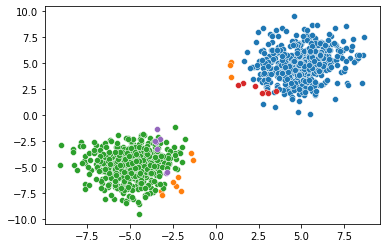

In [238]:
#scatterplot of clusters from last recorded iteration
for h in range(k):
    currd = data[cluster_allocs_recorded == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

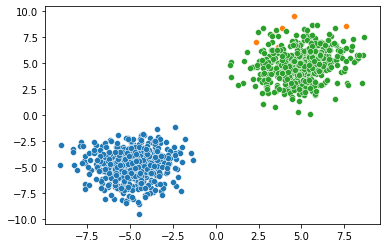

In [203]:
#scatterplot of clusters from last iteration
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd])

In [24]:
for it in range(len(uniq_vals_out)):
    x, y = np.unique(allocs_out[it], return_counts=True)
    plt.bar(x, y)
    plt.show()
    time.sleep(0.1)
    plt.clf()



NameError: name 'uniq_vals_out' is not defined

In [204]:
uniq_vals_out[-1]

array([[[-4.88790476e+00,  1.40772599e+00,  2.49543196e-01],
        [-4.87126063e+00,  2.49543196e-01,  2.00560808e+00]],

       [[-2.65885634e-03,  2.58835994e+00, -7.79302002e-01],
        [ 7.55276079e-02, -7.79302002e-01,  4.43536424e-01]],

       [[-3.38830096e-01,  4.88673097e-01, -6.70115771e-01],
        [-1.17285868e-01, -6.70115771e-01,  1.41975872e+00]],

       [[ 4.51684073e+00,  4.11878919e+00,  2.23202626e+00],
        [ 6.89150691e+00,  2.23202626e+00,  3.13062623e+00]],

       [[ 4.97406618e+00,  1.67875585e+00,  5.51112464e-01],
        [ 4.76308333e+00,  5.51112464e-01,  2.13658604e+00]],

       [[ 2.23923999e-01,  9.67016208e-02,  4.41878035e-01],
        [ 2.44922374e+00,  4.41878035e-01,  2.64645342e+00]],

       [[ 7.51288154e-01,  3.56847681e+00,  9.39804521e-01],
        [-4.46038942e-01,  9.39804521e-01,  2.63124149e-01]],

       [[-2.21569641e+00,  6.39035515e-01,  5.88764479e-01],
        [-4.16212939e+00,  5.88764479e-01,  1.14494911e+01]]])

In [150]:
len(uniq_vals_out)

299